In [2]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import gc
import matplotlib.pyplot as plt
import zipfile
from sklearn.linear_model import LinearRegression

2025-02-09 16:52:36.165230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-09 16:52:36.165272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-09 16:52:36.166478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 16:52:36.172487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-09 16:52:36.914419: W tensorflow/compiler/tf2

In [3]:
csv1, csv2, csv3, csvtest = './sliced_datasets/Chess_1.csv', './sliced_datasets/Chess_2.csv', './sliced_datasets/Chess_3.csv', './sliced_datasets/test_track_8.csv'
df1, df2, df3, dftest = pd.read_csv(csv1), pd.read_csv(csv2), pd.read_csv(csv3), pd.read_csv(csvtest)

In [4]:
df = pd.concat([df1,df2,df3], axis = 0).reset_index(drop = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   FEN         300000 non-null  object
 1   Evaluation  300000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


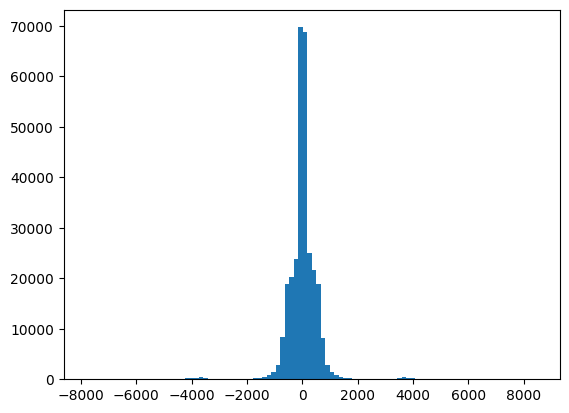

In [6]:
plt.hist(df['Evaluation'], bins=100)
plt.show()

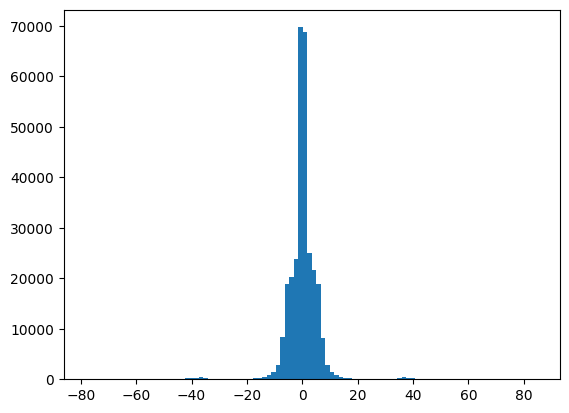

In [7]:
plt.hist(df['Evaluation']/100, bins=100)
plt.show()

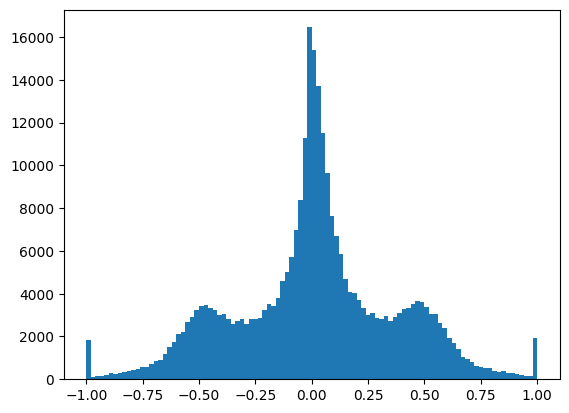

In [8]:
plt.hist(df['Evaluation'].div(994.33977).pipe(np.tanh).round(10), bins=100)
plt.show()

In [9]:
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df2['Evaluation'] = df['Evaluation']/100
df3['Evaluation'] = (df['Evaluation'].div(994.33977).pipe(np.tanh).round(10))
len(df['Evaluation'].unique()), len(df2['Evaluation'].unique()), len(df3['Evaluation'].unique())

(5297, 5297, 5297)

In [10]:
fen_cols = ['FEN_board', 'next', 'CA', '_', 'hm', 'fm']
df[fen_cols] = df['FEN'].str.split(' ', expand=True)
df.drop(['_', 'FEN'], axis=1, inplace=True)


df['next'] = df['next'].map({'b': -1, 'w': 1}).astype(np.int8)


castlingdict = {'K': 'CA_K', 'Q': 'CA_Q', 'k': 'CA_k', 'q': 'CA_q'}
for char, col in castlingdict.items():
    df[col] = df['CA'].str.contains(char).astype(np.int8)
df.drop('CA', axis=1, inplace=True)


df['hm'] = df['hm'].astype(np.int64)
df['fm'] = df['fm'].astype(np.int64)


def numbw(fen_str):
    blk= {
    'p': 0,  
    'r': 0,  
    'n': 0,  
    'b': 0,  
    'q': 0,  
    'k': 0,  
    }
    wht = {
    'P': 0,  
    'R': 0,  
    'N': 0,  
    'B': 0,  
    'Q': 0,  
    'K': 0,  
    }
    for c in fen_str:
        if c.islower():  
            blk[c] = blk.get(c, 0) + 1
        elif c.isupper():  
            wht[c] = wht.get(c, 0) + 1

    return blk, wht

df[['numb', 'numw']] = pd.DataFrame(df['FEN_board'].apply(numbw).tolist())


In [11]:
# df

In [12]:
from scipy.stats import zscore

df['Z_score'] = zscore(df['Evaluation'])
print("Data before removing outliers:", len(df))
df4 = df[(df['Z_score'] <= 3) & (df['Z_score'] >= -3)]
print("Data after removing outliers:", len(df4))

Data before removing outliers: 300000
Data after removing outliers: 295749


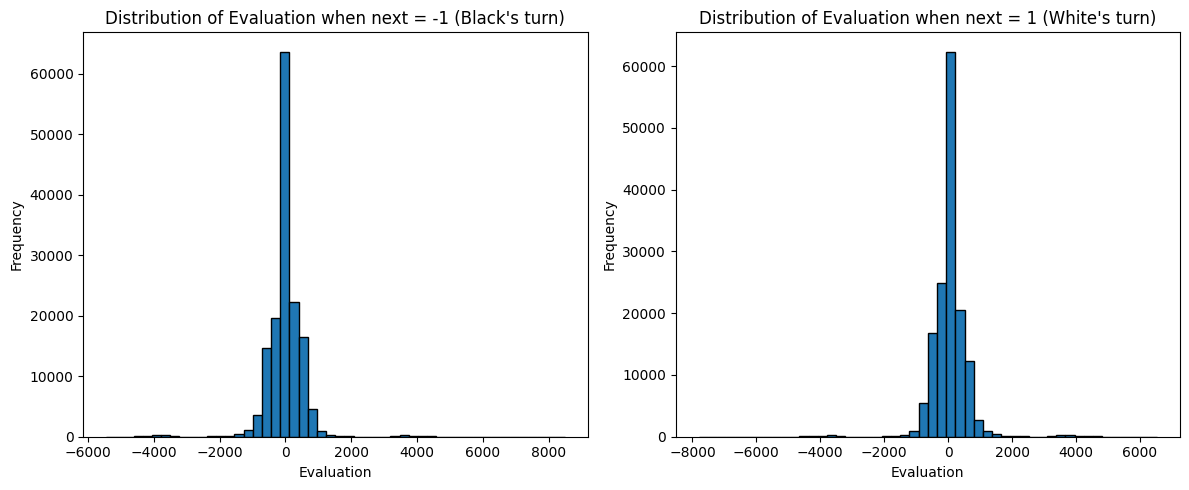

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(df[df['next'] == -1]['Evaluation'], bins=50, edgecolor='black')
ax1.set_title("Distribution of Evaluation when next = -1 (Black's turn)")
ax1.set_xlabel('Evaluation')
ax1.set_ylabel('Frequency')

ax2.hist(df[df['next'] == 1]['Evaluation'], bins=50, edgecolor='black')
ax2.set_title("Distribution of Evaluation when next = 1 (White's turn)")
ax2.set_xlabel('Evaluation')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [14]:
df

,Evaluation,FEN_board,next,hm,fm,CA_K,CA_Q,CA_k,CA_q,numb,numw,Z_score
0,16,r2q1rk1/pb3pbp/1ppp1np1/2nPp3/4P3/2P1B2P/PPBNN...,1,0,12,0,0,0,0,"{'p': 8, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}",0.000100
1,-929,r7/ppQ1n2p/2n1k1p1/1N1p1q2/1P1P4/2P3P1/P7/2K5,-1,0,24,0,0,0,0,"{'p': 5, 'r': 1, 'n': 2, 'b': 0, 'q': 1, 'k': 1}","{'P': 5, 'R': 0, 'N': 1, 'B': 0, 'Q': 1, 'K': 1}",-1.613778
2,4,r1bq1rk1/ppp1bppp/2n2n2/3Pp3/2B5/2PP1N1P/PP3PP...,-1,0,7,1,1,0,0,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}",-0.020393
3,546,6k1/R2b2r1/8/7R/2PPP3/8/7P/5K2,-1,0,42,0,0,0,0,"{'p': 0, 'r': 1, 'n': 0, 'b': 1, 'q': 0, 'k': 1}","{'P': 4, 'R': 2, 'N': 0, 'B': 0, 'Q': 0, 'K': 1}",0.905239
4,684,r4r2/pp4pp/k1nQ1q2/5P2/2B5/8/P5PP/1R3RK1,-1,4,27,0,0,0,0,"{'p': 4, 'r': 2, 'n': 1, 'b': 0, 'q': 1, 'k': 1}","{'P': 4, 'R': 2, 'N': 0, 'B': 1, 'Q': 1, 'K': 1}",1.140916
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-230,r5r1/p1p1kqbQ/bp1p4/4pP2/7p/2P4P/P1P2PPB/2KRR3,1,0,22,0,0,0,0,"{'p': 6, 'r': 2, 'n': 0, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 0, 'B': 1, 'Q': 1, 'K': 1}",-0.420021
299996,-14,r1b1k2r/pp4p1/2n1pq1p/bB1p4/3P4/P1N2N2/1P3PPP/...,-1,2,12,1,1,1,1,"{'p': 6, 'r': 2, 'n': 1, 'b': 2, 'q': 1, 'k': 1}","{'P': 6, 'R': 2, 'N': 2, 'B': 1, 'Q': 1, 'K': 1}",-0.051134
299997,178,rnbqkbnr/p5pp/2p2p2/4p3/Np6/1B1P1N2/PPP2PPP/R1...,-1,1,9,1,1,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}",0.276765
299998,357,6k1/3n4/7p/5pp1/3Kp3/3NP2P/1P1N1PP1/8,-1,0,33,0,0,0,0,"{'p': 4, 'r': 0, 'n': 1, 'b': 0, 'q': 0, 'k': 1}","{'P': 5, 'R': 0, 'N': 2, 'B': 0, 'Q': 0, 'K': 1}",0.582463


In [15]:
df['#B'] = df['numb'].apply(lambda x: sum(x.values()))
df['#W'] = df['numw'].apply(lambda x: sum(x.values()))

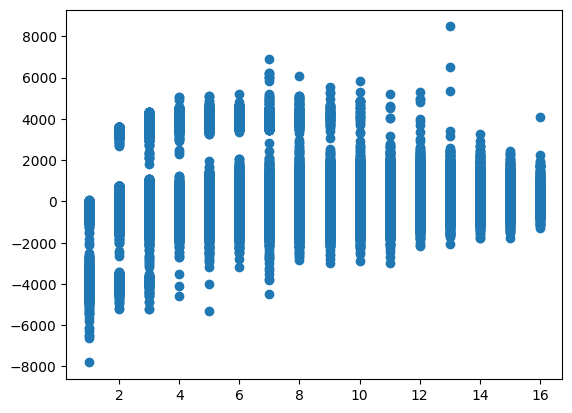

In [16]:
plt.scatter(df["#W"],df["Evaluation"])
plt.show()

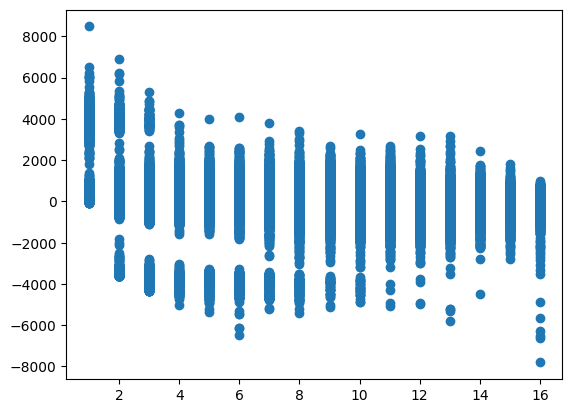

In [17]:
plt.scatter(df["#B"],df["Evaluation"])
plt.show()

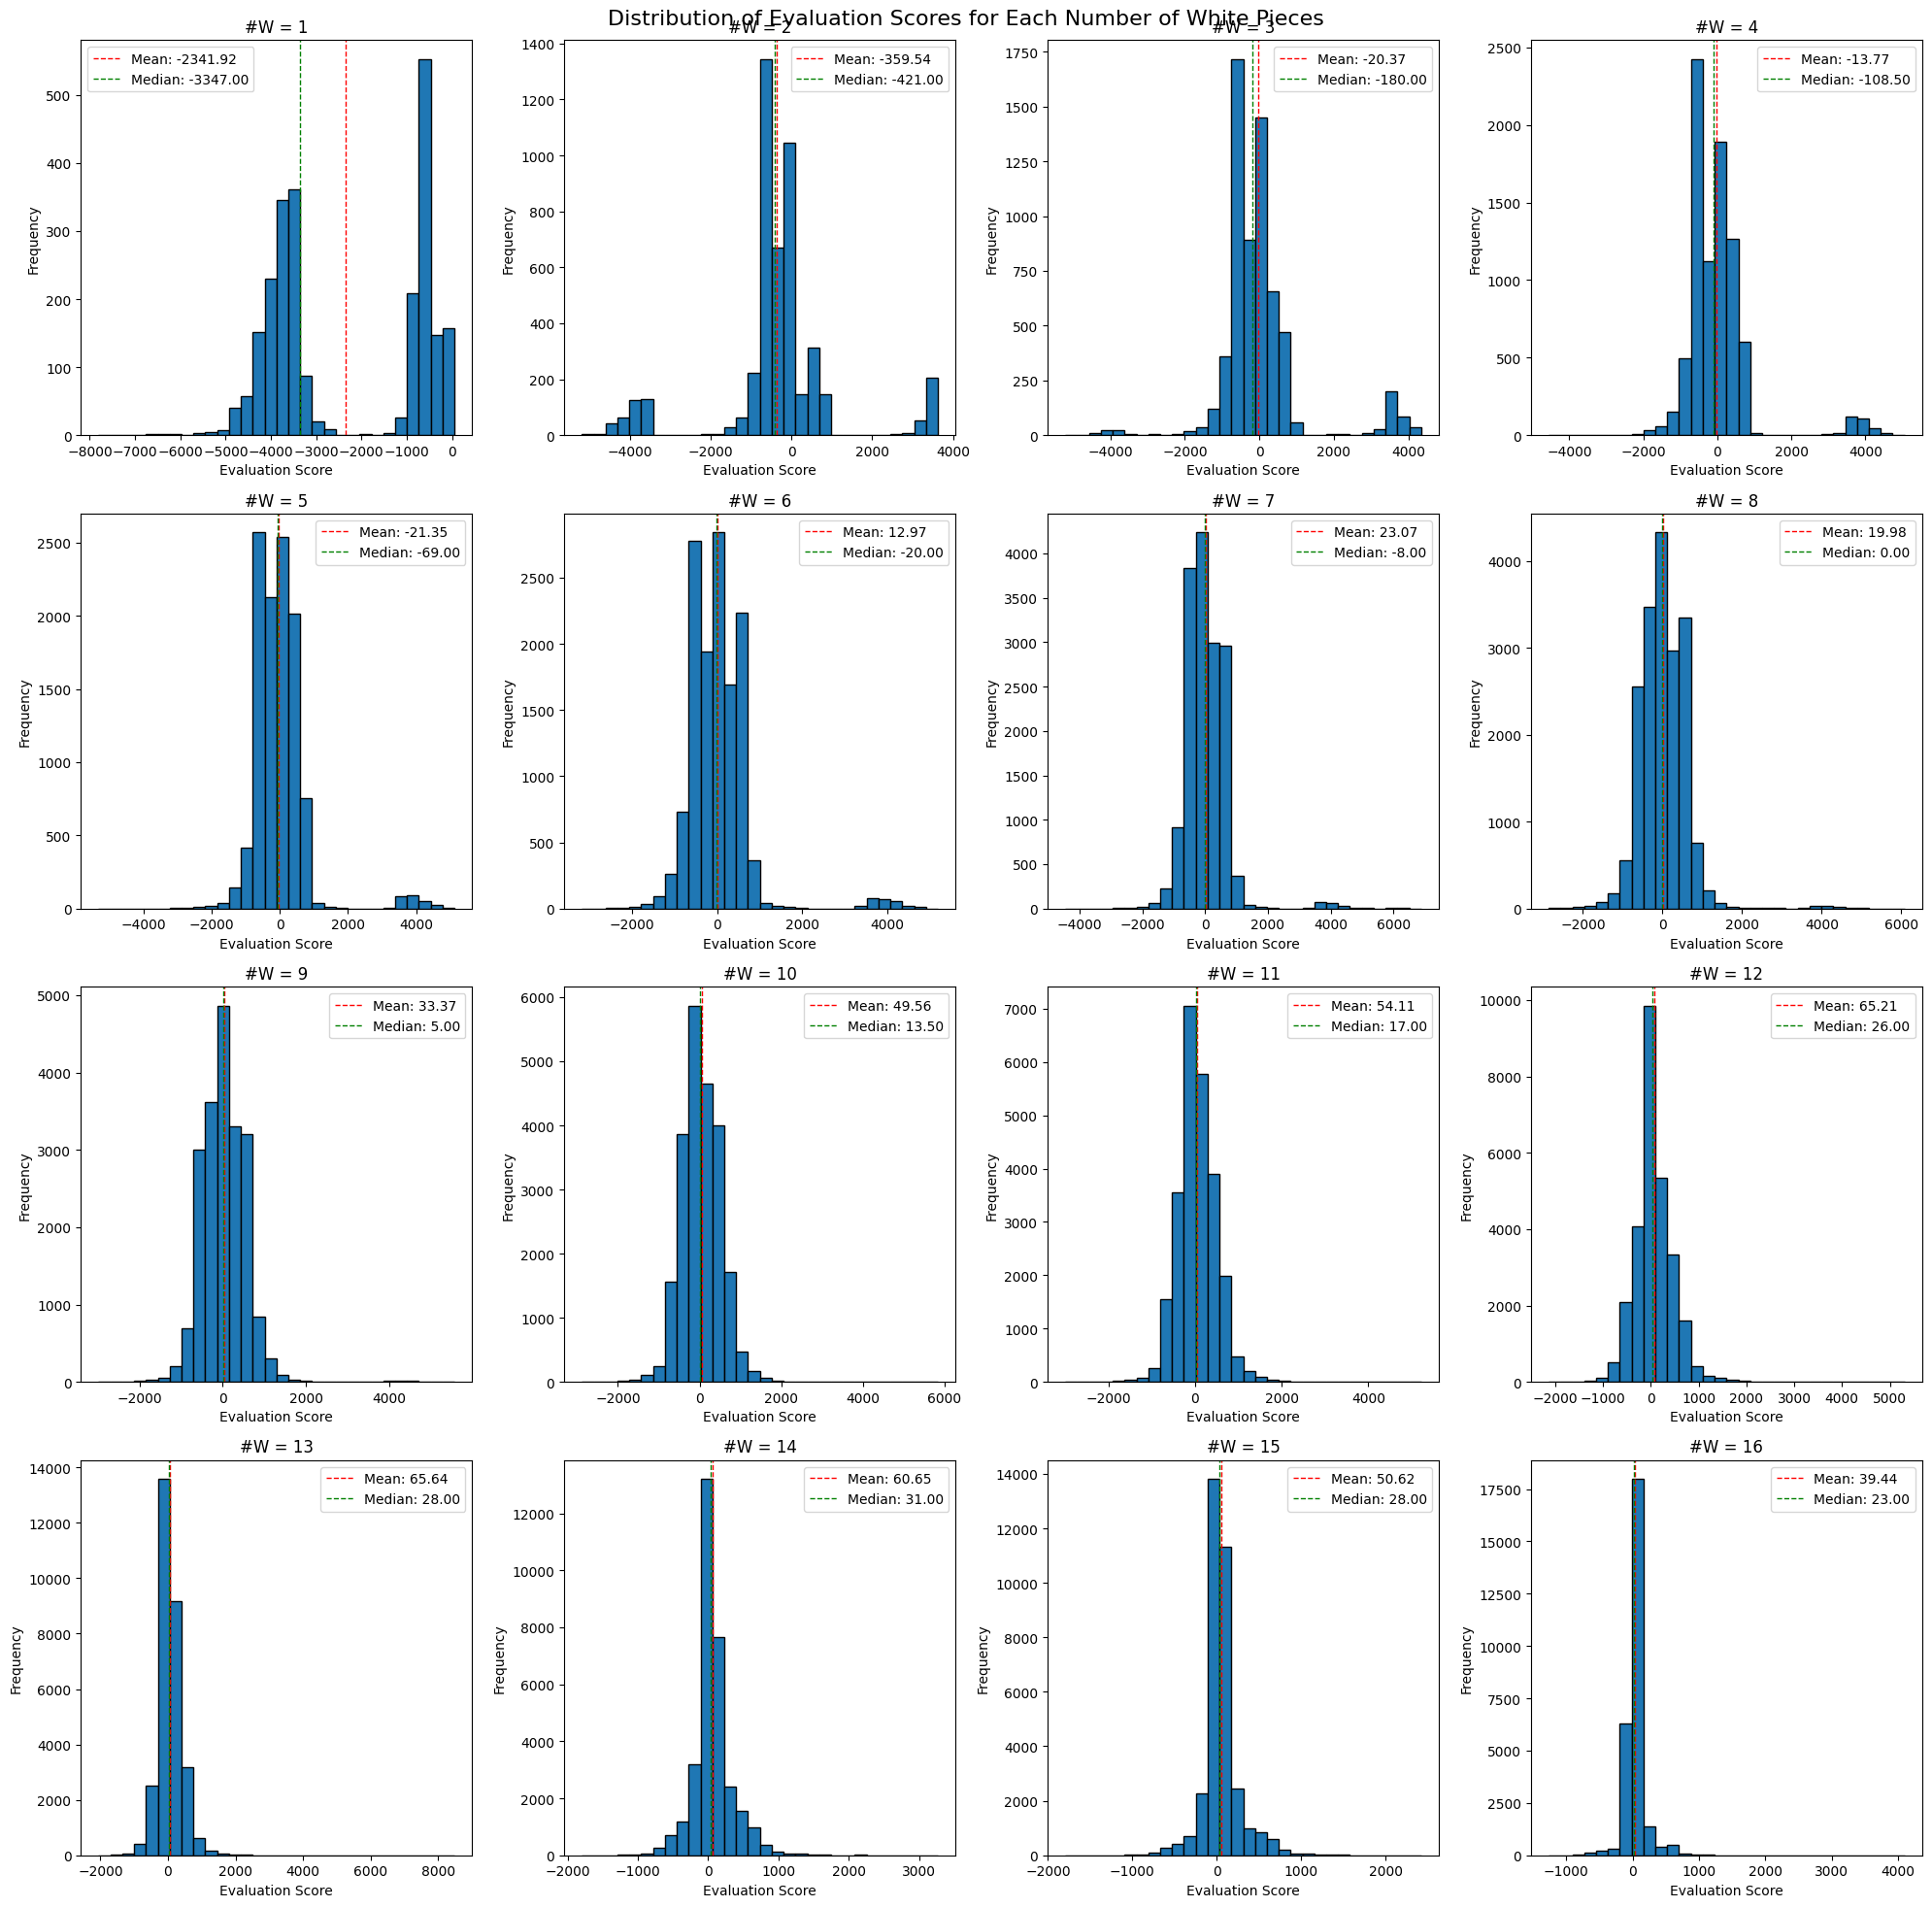

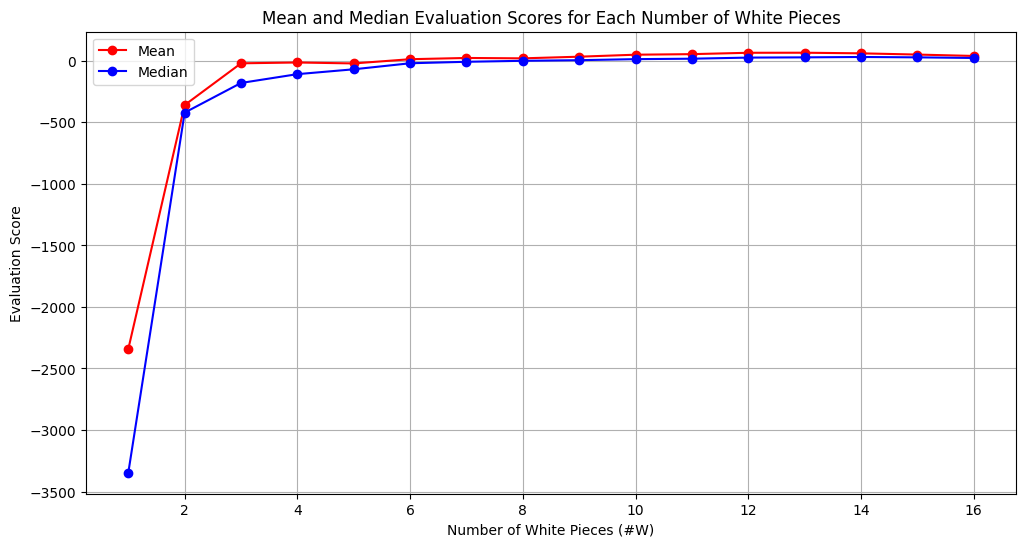

In [18]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Distribution of Evaluation Scores for Each Number of White Pieces', fontsize=16)

axs = axs.flatten()

for i in range(1, 17):
    ax = axs[i-1]
    data = df[df['#W'] == i]['Evaluation']
    ax.hist(data, bins=30, edgecolor='black')
    ax.set_title(f'#W = {i}')
    ax.set_xlabel('Evaluation Score')
    ax.set_ylabel('Frequency')
    
    mean = data.mean()
    median = data.median()
    ax.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    ax.axvline(median, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
means = [df[df['#W'] == i]['Evaluation'].mean() for i in range(1, 17)]
medians = [df[df['#W'] == i]['Evaluation'].median() for i in range(1, 17)]
plt.plot(range(1, 17), means, 'ro-', label='Mean')
plt.plot(range(1, 17), medians, 'bo-', label='Median')
plt.title('Mean and Median Evaluation Scores for Each Number of White Pieces')
plt.xlabel('Number of White Pieces (#W)')
plt.ylabel('Evaluation Score')
plt.legend()
plt.grid(True)
plt.show()

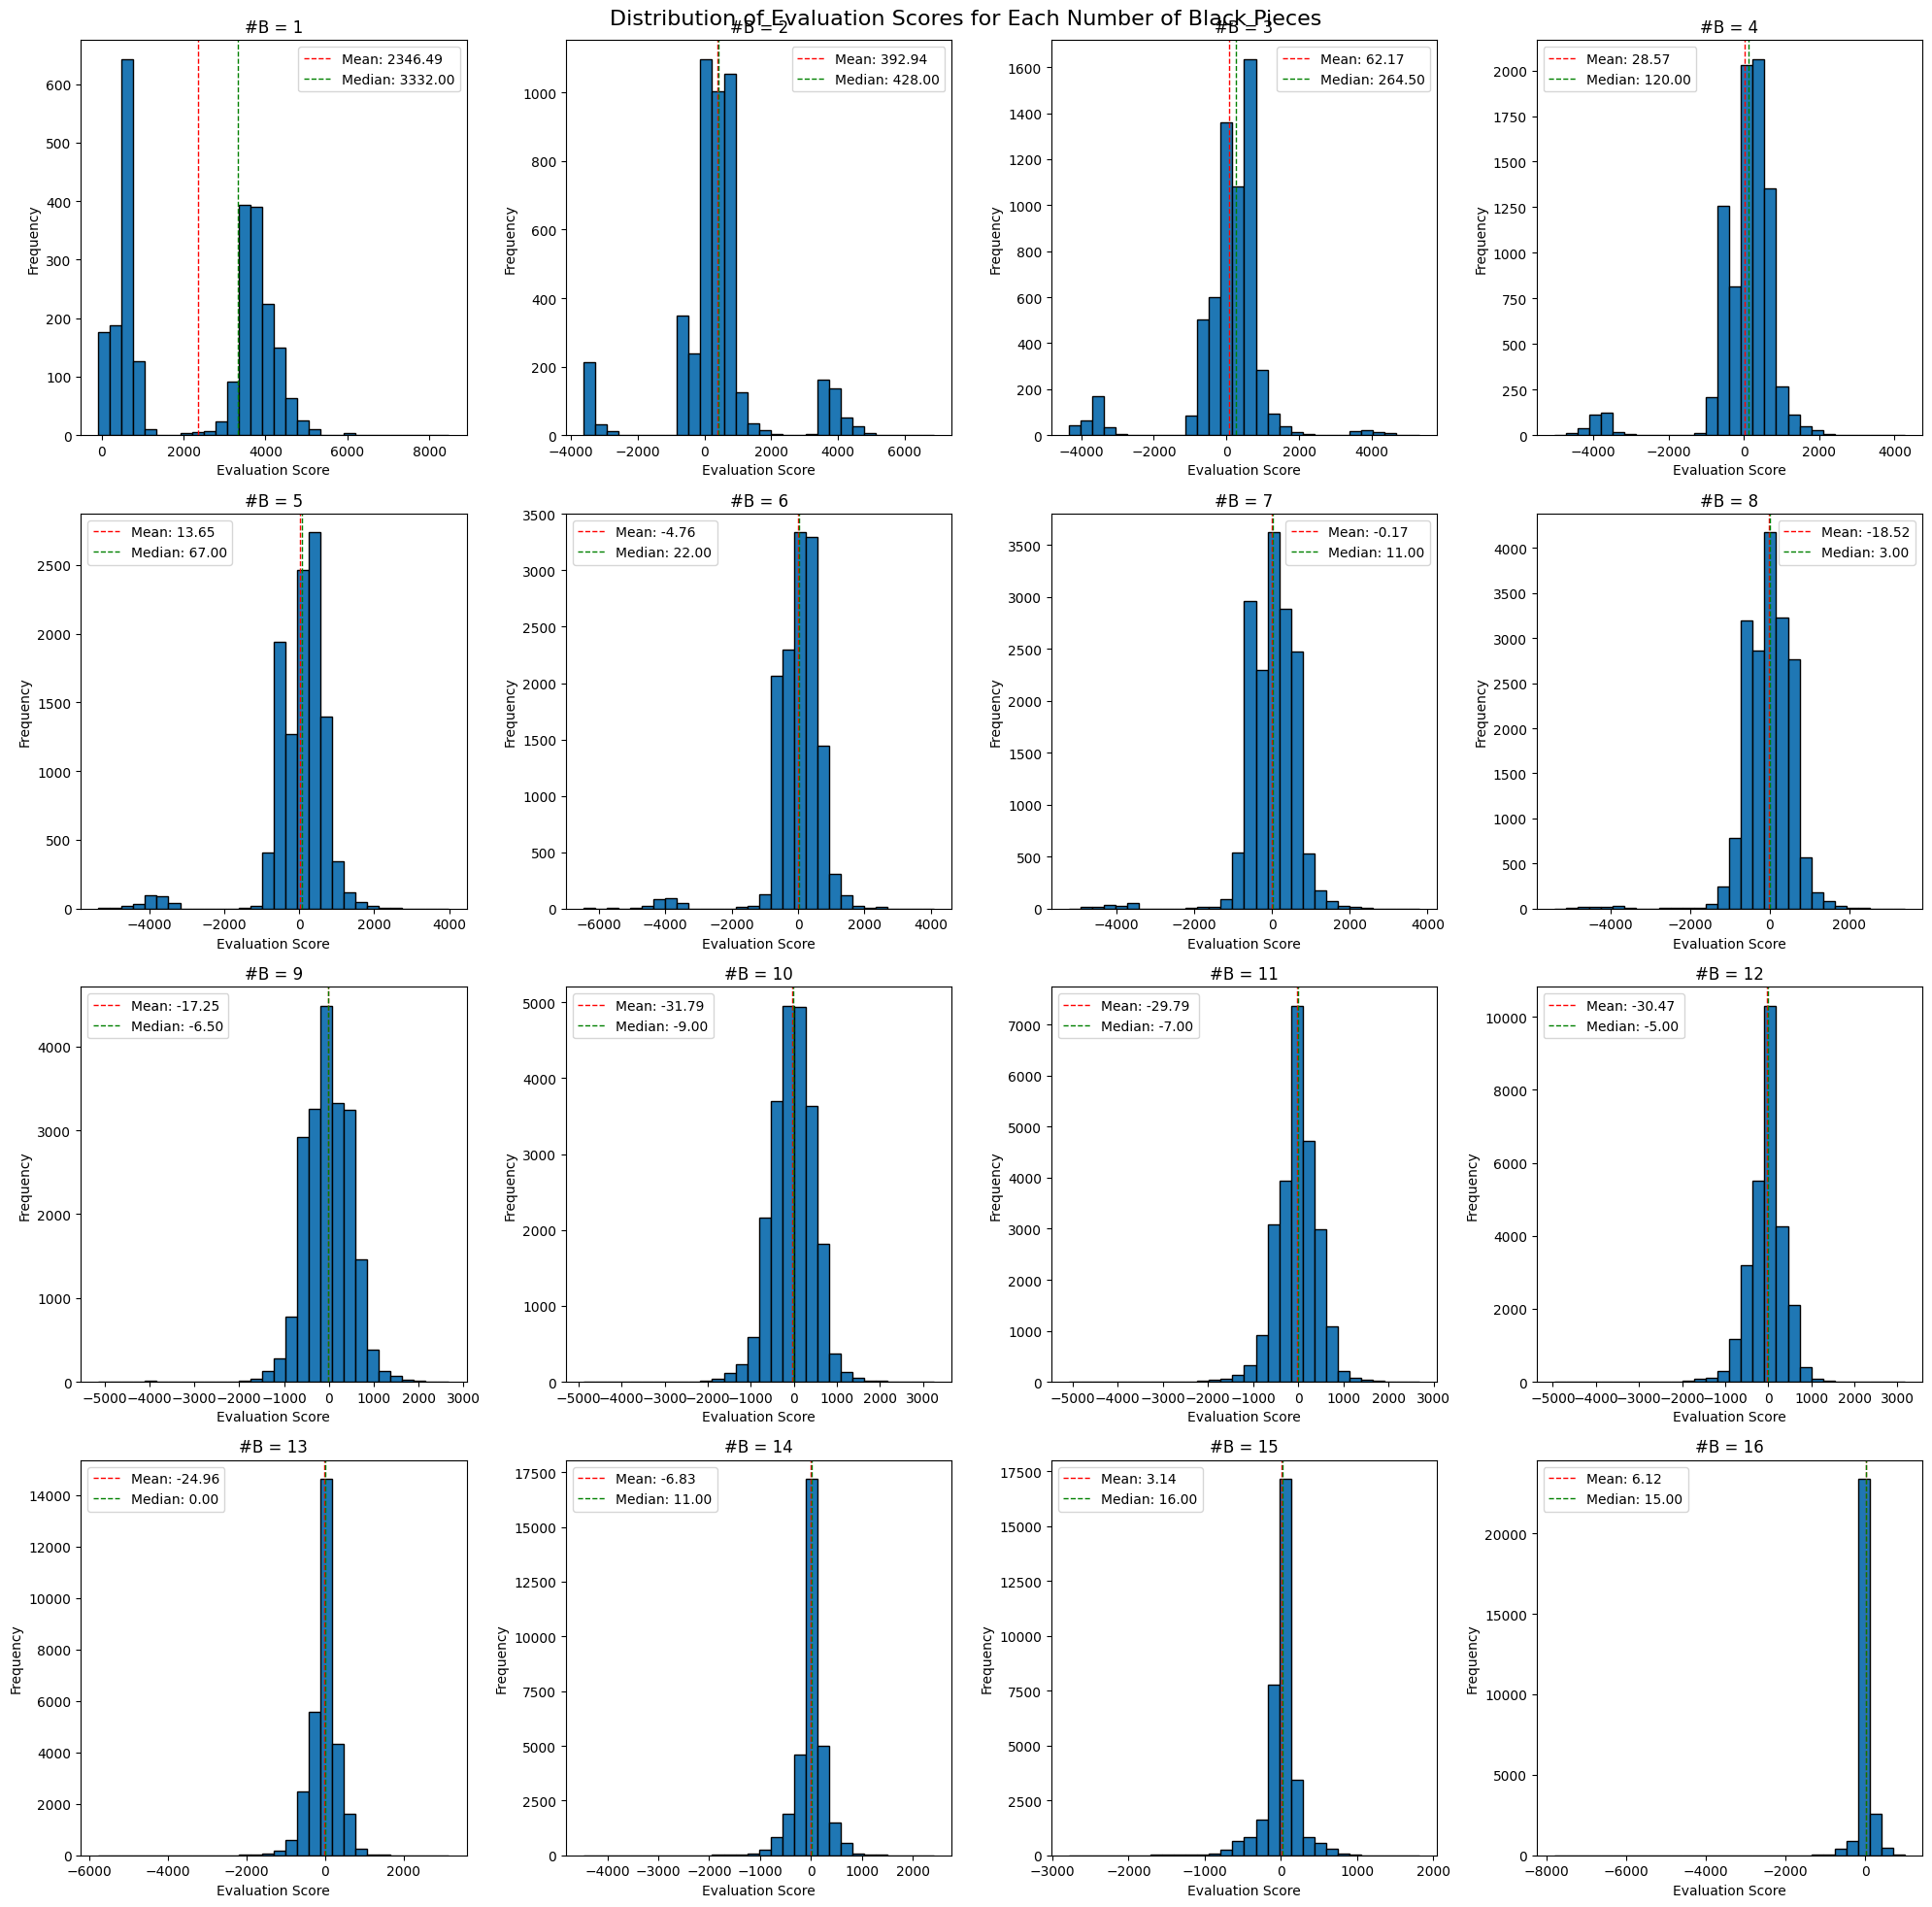

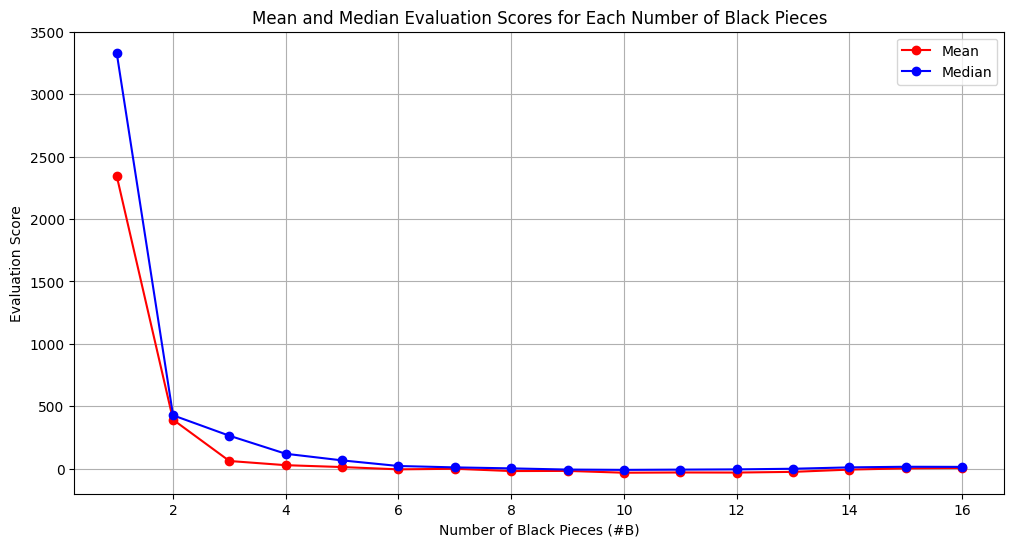

In [19]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Distribution of Evaluation Scores for Each Number of Black Pieces', fontsize=16)

axs = axs.flatten()

for i in range(1, 17):
    ax = axs[i-1]
    data = df[df['#B'] == i]['Evaluation']
    ax.hist(data, bins=30, edgecolor='black')
    ax.set_title(f'#B = {i}')
    ax.set_xlabel('Evaluation Score')
    ax.set_ylabel('Frequency')
    
    mean = data.mean()
    median = data.median()
    ax.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    ax.axvline(median, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
means = [df[df['#B'] == i]['Evaluation'].mean() for i in range(1, 17)]
medians = [df[df['#B'] == i]['Evaluation'].median() for i in range(1, 17)]
plt.plot(range(1, 17), means, 'ro-', label='Mean')
plt.plot(range(1, 17), medians, 'bo-', label='Median')
plt.title('Mean and Median Evaluation Scores for Each Number of Black Pieces')
plt.xlabel('Number of Black Pieces (#B)')
plt.ylabel('Evaluation Score')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
piece_weights = {
    'p': 1,  
    'r': 5,  
    'n': 3,  
    'b': 3,  
    'q': 9,  
    'k': 0,  
}

def weighted_sum(piece_counts, piece_weights):
    weighted_sum = 0
    for piece, count in piece_counts.items():
        weight = piece_weights.get(piece.lower(), 0)
        weighted_sum += count * weight
    return weighted_sum

df['wtdb'] = df['numb'].apply(lambda blk: weighted_sum(blk, piece_weights))
df['wtdw'] = df['numw'].apply(lambda wht: weighted_sum(wht, piece_weights))

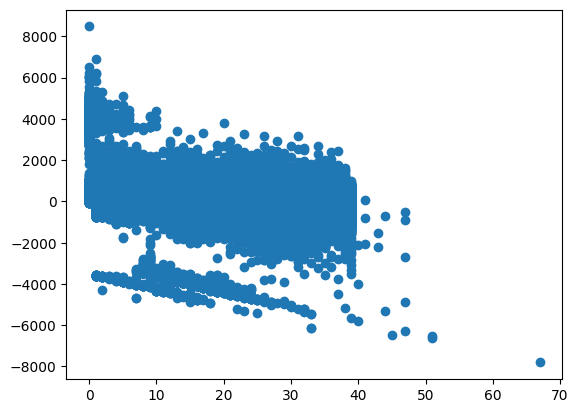

In [21]:
plt.scatter(df["wtdb"],df["Evaluation"])
plt.show()

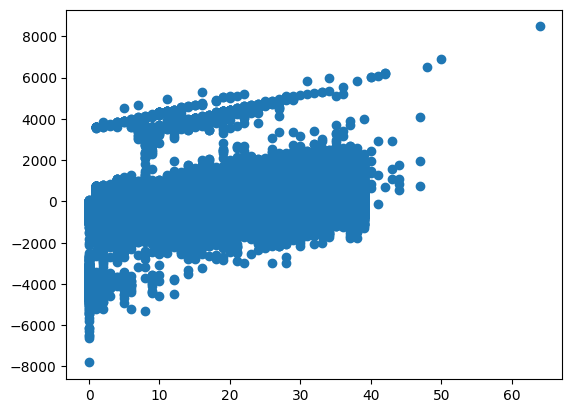

In [22]:
plt.scatter(df["wtdw"],df["Evaluation"])
plt.show()

In [23]:
black_pieces = pd.json_normalize(df['numb'])
white_pieces = pd.json_normalize(df['numw'])

X = pd.concat([black_pieces, white_pieces], axis=1)
y = df['Evaluation']

model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [24]:
black_weights = dict(zip(black_pieces.columns, model.coef_[:6]))
white_weights = dict(zip(white_pieces.columns, model.coef_[6:]))

In [25]:
white_weights

{'P': 129.80182169666838,
 'R': 490.7844572280178,
 'N': 316.9618465963061,
 'B': 354.8315553994522,
 'Q': 937.3200167799201,
 'K': 0.0}

In [26]:
black_weights

{'p': -133.23941840678827,
 'r': -488.6501130856525,
 'n': -309.8117720675912,
 'b': -347.6213057452584,
 'q': -923.3755581785258,
 'k': -3.410605131648481e-13}

In [27]:
def weighted_sum(piece_counts, piece_weights):
    weighted_sum = 0
    for piece, count in piece_counts.items():
        weight = piece_weights.get(piece, 0)
        weighted_sum += count * weight
    return weighted_sum

df['wtdb'] = df['numb'].apply(lambda blk: weighted_sum(blk, black_weights))
df['wtdw'] = df['numw'].apply(lambda wht: weighted_sum(wht, white_weights))

In [28]:
from scipy.stats import zscore

df['Z_score'] = zscore(df['Evaluation'])
print("Data before removing outliers:", len(df))
df = df[(df['Z_score'] <= 3) & (df['Z_score'] >= -3)]
print("Data after removing outliers:", len(df))

Data before removing outliers: 300000
Data after removing outliers: 295749


In [29]:
df

,Evaluation,FEN_board,next,hm,fm,CA_K,CA_Q,CA_k,CA_q,numb,numw,Z_score,#B,#W,wtdb,wtdw
0,16,r2q1rk1/pb3pbp/1ppp1np1/2nPp3/4P3/2P1B2P/PPBNN...,1,0,12,0,0,0,0,"{'p': 8, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}",0.000100,16,16,-4281.457287,4300.890309
1,-929,r7/ppQ1n2p/2n1k1p1/1N1p1q2/1P1P4/2P3P1/P7/2K5,-1,0,24,0,0,0,0,"{'p': 5, 'r': 1, 'n': 2, 'b': 0, 'q': 1, 'k': 1}","{'P': 5, 'R': 0, 'N': 1, 'B': 0, 'Q': 1, 'K': 1}",-1.613778,10,8,-2697.846307,1903.290972
2,4,r1bq1rk1/ppp1bppp/2n2n2/3Pp3/2B5/2PP1N1P/PP3PP...,-1,0,7,1,1,0,0,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 8, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}",-0.020393,15,16,-4148.217869,4300.890309
3,546,6k1/R2b2r1/8/7R/2PPP3/8/7P/5K2,-1,0,42,0,0,0,0,"{'p': 0, 'r': 1, 'n': 0, 'b': 1, 'q': 0, 'k': 1}","{'P': 4, 'R': 2, 'N': 0, 'B': 0, 'Q': 0, 'K': 1}",0.905239,3,7,-836.271419,1500.776201
4,684,r4r2/pp4pp/k1nQ1q2/5P2/2B5/8/P5PP/1R3RK1,-1,4,27,0,0,0,0,"{'p': 4, 'r': 2, 'n': 1, 'b': 0, 'q': 1, 'k': 1}","{'P': 4, 'R': 2, 'N': 0, 'B': 1, 'Q': 1, 'K': 1}",1.140916,9,9,-2743.445230,2792.927773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-230,r5r1/p1p1kqbQ/bp1p4/4pP2/7p/2P4P/P1P2PPB/2KRR3,1,0,22,0,0,0,0,"{'p': 6, 'r': 2, 'n': 0, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 0, 'B': 1, 'Q': 1, 'K': 1}",-0.420021,12,12,-3395.354906,3182.333239
299996,-14,r1b1k2r/pp4p1/2n1pq1p/bB1p4/3P4/P1N2N2/1P3PPP/...,-1,2,12,1,1,1,1,"{'p': 6, 'r': 2, 'n': 1, 'b': 2, 'q': 1, 'k': 1}","{'P': 6, 'R': 2, 'N': 2, 'B': 1, 'Q': 1, 'K': 1}",-0.051134,13,13,-3705.166678,3686.455110
299997,178,rnbqkbnr/p5pp/2p2p2/4p3/Np6/1B1P1N2/PPP2PPP/R1...,-1,1,9,1,1,1,1,"{'p': 7, 'r': 2, 'n': 2, 'b': 2, 'q': 1, 'k': 1}","{'P': 7, 'R': 2, 'N': 2, 'B': 2, 'Q': 1, 'K': 1}",0.276765,15,15,-4148.217869,4171.088487
299998,357,6k1/3n4/7p/5pp1/3Kp3/3NP2P/1P1N1PP1/8,-1,0,33,0,0,0,0,"{'p': 4, 'r': 0, 'n': 1, 'b': 0, 'q': 0, 'k': 1}","{'P': 5, 'R': 0, 'N': 2, 'B': 0, 'Q': 0, 'K': 1}",0.582463,6,8,-842.769446,1282.932802


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def makemodel2d_base():
    cube_input = Input(shape=(8, 8, 1), name='image_input')

    casting = layers.Conv2D(16, (3, 3), activation=None, padding='same')(cube_input)
    casting = layers.BatchNormalization()(casting)

    x = layers.Conv2D(16, (3, 3), activation=None, padding='same')(casting)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (2, 2), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    vector_input1 = Input(shape=(4,), name='vector_input1')
    y1 = layers.Dense(16, activation='relu')(vector_input1)
    y1 = layers.Dense(32, activation='relu')(y1)

    vector_input2 = Input(shape=(3,), name='vector_input2')
    y2 = layers.Dense(16, activation='relu')(vector_input2)
    y2 = layers.Dense(32, activation='relu')(y2)

    combined = layers.Concatenate()([x, y1, y2])

    z = layers.Dense(128, activation=None)(combined)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(64, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dropout(0.5)(z)

    z = layers.Dense(32, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(16, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(4, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    output = layers.Dense(1, activation='linear', name='output')(z)

    model = Model(inputs=[cube_input, vector_input1, vector_input2], outputs=output)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-2,
        weight_decay=1e-3
    )

    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    return model


In [31]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def makemodel2d():
    cube_input = Input(shape=(8, 8, 1), name='image_input')

    casting = layers.Conv2D(16, (3, 3), activation=None, padding='same')(cube_input)
    casting = layers.BatchNormalization()(casting)

    x = layers.Conv2D(16, (3, 3), activation=None, padding='same')(casting)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (2, 2), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    vector_input1 = Input(shape=(4,), name='vector_input1')
    y1 = layers.Dense(16, activation='relu')(vector_input1)
    y1 = layers.Dense(32, activation='relu')(y1)

    vector_input2 = Input(shape=(3,), name='vector_input2')
    y2 = layers.Dense(16, activation='relu')(vector_input2)
    y2 = layers.Dense(32, activation='relu')(y2)

    vector_input3 = Input(shape=(2,), name='vector_input3')
    y3 = layers.Dense(16, activation='relu')(vector_input3)
    y3 = layers.Dense(32, activation='relu')(y3)

    combined = layers.Concatenate()([x, y1, y2, y3])

    z = layers.Dense(128, activation=None)(combined)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(64, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dropout(0.5)(z)

    z = layers.Dense(32, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(16, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(4, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    output = layers.Dense(1, activation='linear', name='output')(z)

    model = Model(inputs=[cube_input, vector_input1, vector_input2, vector_input3], outputs=output)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-2,
        weight_decay=1e-3
    )

    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    return model


In [32]:
def fen2board(fen, tonum):
    board = np.empty(64, dtype=np.int8)
    i = 0
    for row in fen.split('/'):
        for c in row:
            if c.isdigit():
                i += int(c)
            else:
                board[i] = tonum[c]
                i += 1
    return board

In [33]:
tonum1 = {
    'P': 1, 'N': 2, 'B': 5, 'R': 7, 'Q': 15, 'K': 10,
    'p': -1, 'n': -2, 'b': -5, 'r': -7, 'q': -15, 'k': -10
}

tonum2 = {
    'P':0, 'N':1, 'B':2, 'R':3, 'Q':4, 'K':5,
    'p':6, 'n':7, 'b':8, 'r':9, 'q':10, 'k':11
}

tonum3 = {
    'P': 1, 'N': 2, 'B': 5, 'R': 7, 'Q': 15, 'K': 100,
    'p': -1, 'n': -2, 'b': -5, 'r': -7, 'q': -15, 'k': -100
}


In [34]:
df['board1'] = [fen2board(f, tonum1) for f in df['FEN_board']]
df['board2'] = [fen2board(f, tonum2) for f in df['FEN_board']]
df['board3'] = [fen2board(f, tonum3) for f in df['FEN_board']]

/tmp/ipykernel_43912/1483347391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['board1'] = [fen2board(f, tonum1) for f in df['FEN_board']]


/tmp/ipykernel_43912/1483347391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['board2'] = [fen2board(f, tonum2) for f in df['FEN_board']]
/tmp/ipykernel_43912/1483347391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['board3'] = [fen2board(f, tonum3) for f in df['FEN_board']]


In [35]:
boardstacked1 = np.stack(df['board1'].values).reshape(-1, 8, 8)
boardstacked2 = np.stack(df['board2'].values).reshape(-1, 8, 8)
boardstacked3 = np.stack(df['board3'].values).reshape(-1, 8, 8)


In [36]:
vecinp1 = df[['CA_K', 'CA_Q', 'CA_k', 'CA_q']].to_numpy()
vecinp2 = df[['hm', 'fm', 'next']].astype(np.float32).to_numpy()
vecinp3 = df[['wtdb', 'wtdw']].astype(np.float32).to_numpy()

In [37]:
x1 = [boardstacked1, vecinp1, vecinp2]
x2 = [boardstacked2, vecinp1, vecinp2]
x3 = [boardstacked3, vecinp1, vecinp2]

In [38]:
y = df['Evaluation'].values

In [39]:
(boardtr1, boardval1,
 vec1tr1, vec1val1,
 vec2tr1, vec2val1,
 ytr1, yval1) = train_test_split(
    boardstacked1,
    vecinp1,
    vecinp2,
    y,
    test_size=0.2,
    random_state=42
)


(boardtr2, boardval2,
 vec1tr2, vec1val2,
 vec2tr2, vec2val2,
 ytr2, yval2) = train_test_split(
    boardstacked2,
    vecinp1,
    vecinp2,
    y,
    test_size=0.2,
    random_state=42
)


(boardtr3, boardval3,
 vec1tr3, vec1val3,
 vec2tr3, vec2val3,
 ytr3, yval3) = train_test_split(
    boardstacked3,
    vecinp1,
    vecinp2,
    y,
    test_size=0.2,
    random_state=42
)

In [40]:
xtr1 = [boardtr1, vec1tr1, vec2tr1]
xtr2 = [boardtr2, vec1tr2, vec2tr2]
xtr3 = [boardtr3, vec1tr3, vec2tr3]

xval1 = [boardval1, vec1val1, vec2val1]
xval2 = [boardval2, vec1val2, vec2val2]
xval3 = [boardval3, vec1val3, vec2val3]

In [41]:
model1 = makemodel2d_base()
model2 = makemodel2d_base()
model3 = makemodel2d_base()

2025-02-09 16:53:00.925842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [42]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 16)             160       ['image_input[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 16)             64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 16)             2320      ['batch_normalization[0][0

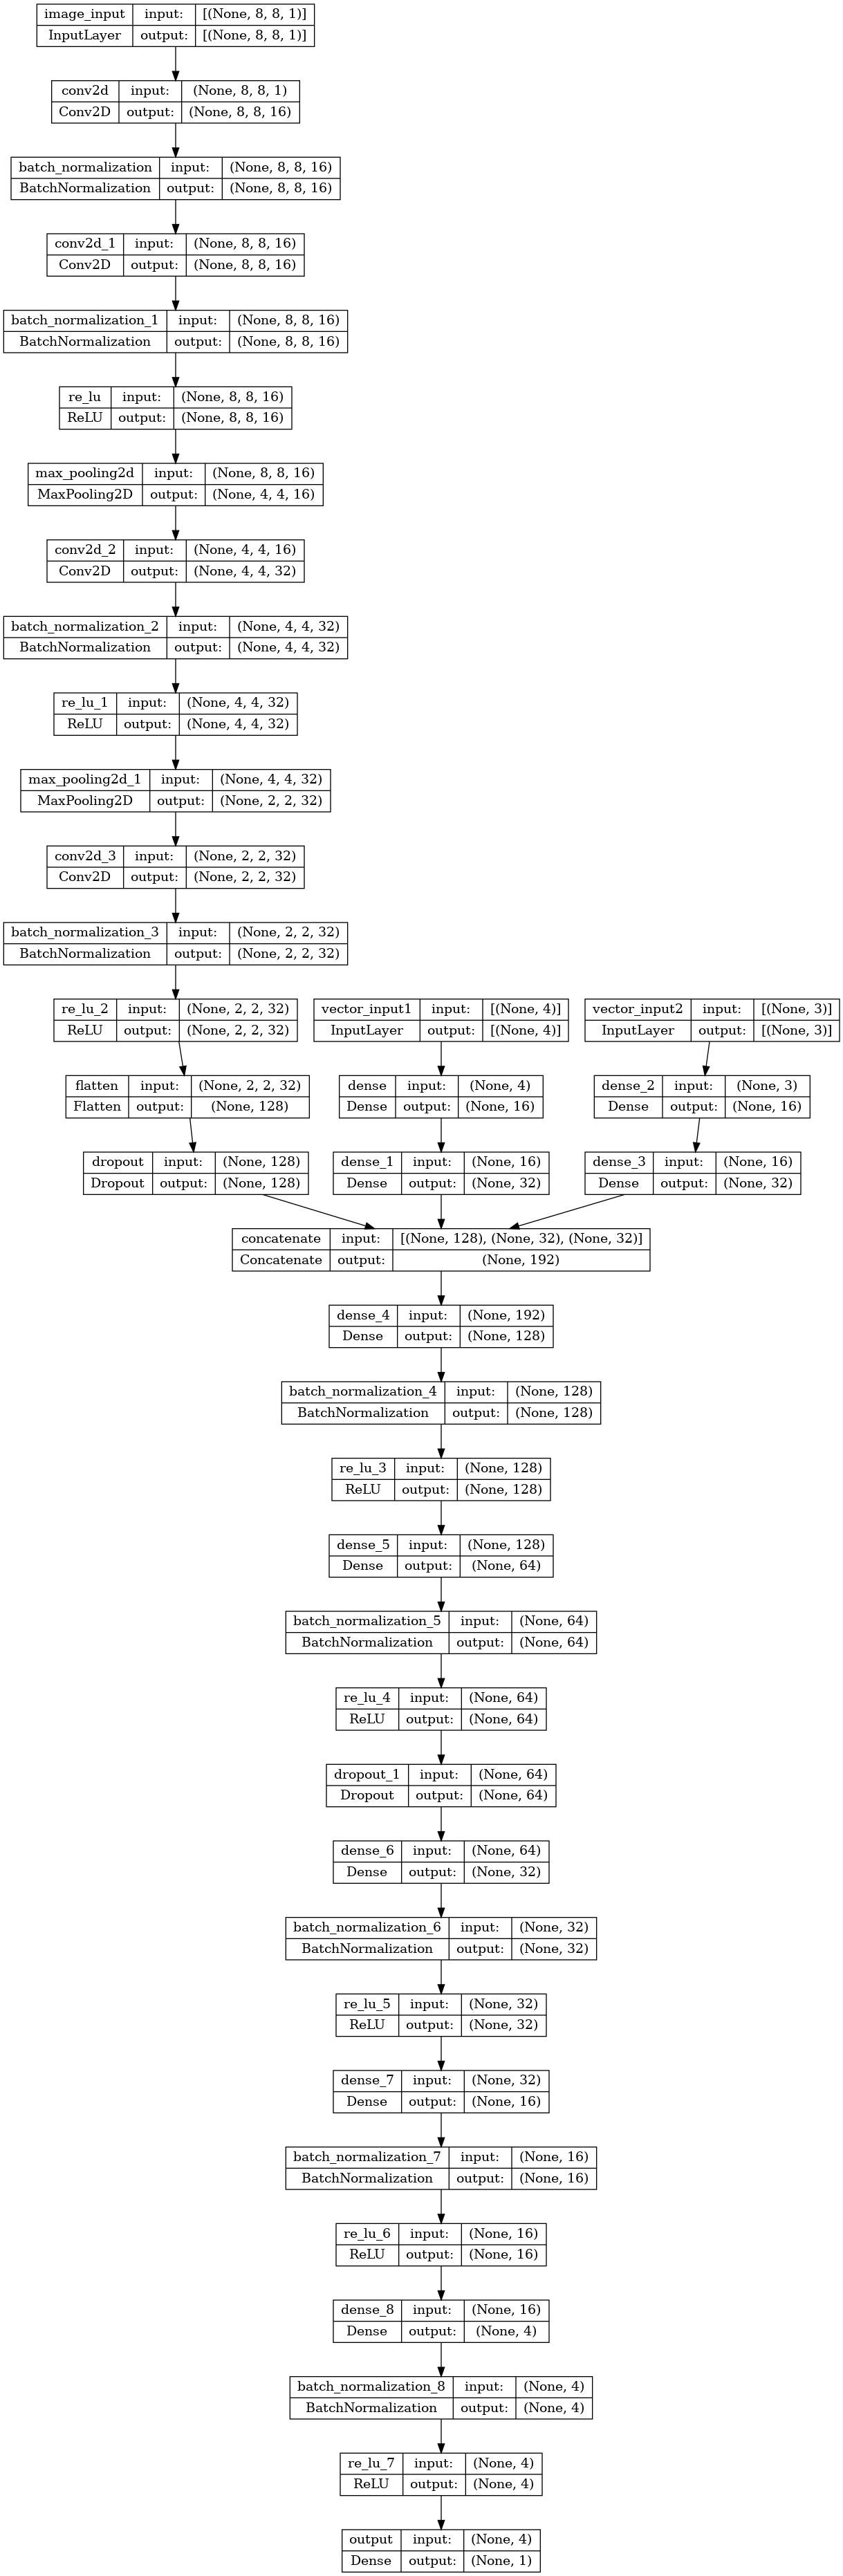

In [43]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model_base.png', show_shapes=True, show_layer_names=True)

In [44]:
history1 = model1.fit(
    xtr1,
    ytr1,
    validation_data=(xval1, yval1),
    epochs=50,
    batch_size=2048
)

Epoch 1/50


2025-02-09 16:53:05.353327: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-02-09 16:53:06.565012: I external/local_xla/xla/service/service.cc:168] XLA service 0x6198ee10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-09 16:53:06.565044: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-02-09 16:53:06.570004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739119986.656972   44078 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


116/116 [==============================] - 9s 15ms/step - loss: 280.7780 - mean_squared_error: 153736.0156 - mean_absolute_error: 280.7780 - val_loss: 306.7724 - val_mean_squared_error: 176276.5156 - val_mean_absolute_error: 306.7724
Epoch 2/50
116/116 [==============================] - 1s 8ms/step - loss: 279.4199 - mean_squared_error: 152544.4062 - mean_absolute_error: 279.4199 - val_loss: 298.8856 - val_mean_squared_error: 163961.0312 - val_mean_absolute_error: 298.8856
Epoch 3/50
116/116 [==============================] - 1s 8ms/step - loss: 278.3794 - mean_squared_error: 151096.5625 - mean_absolute_error: 278.3794 - val_loss: 292.6315 - val_mean_squared_error: 158682.5000 - val_mean_absolute_error: 292.6315
Epoch 4/50
116/116 [==============================] - 1s 8ms/step - loss: 277.4461 - mean_squared_error: 149762.0156 - mean_absolute_error: 277.4461 - val_loss: 279.1949 - val_mean_squared_error: 151704.1094 - val_mean_absolute_error: 279.1949
Epoch 5/50
116/116 [==============

In [45]:
history2 = model2.fit(
    xtr2,
    ytr2,
    validation_data=(xval2, yval2),
    epochs=50,
    batch_size=2048
)

Epoch 1/50


116/116 [==============================] - 6s 12ms/step - loss: 280.6312 - mean_squared_error: 153655.1406 - mean_absolute_error: 280.6312 - val_loss: 304.4556 - val_mean_squared_error: 171076.4219 - val_mean_absolute_error: 304.4556
Epoch 2/50
116/116 [==============================] - 1s 9ms/step - loss: 279.2578 - mean_squared_error: 152412.9219 - mean_absolute_error: 279.2578 - val_loss: 321.7714 - val_mean_squared_error: 185466.6094 - val_mean_absolute_error: 321.7714
Epoch 3/50
116/116 [==============================] - 1s 8ms/step - loss: 278.4514 - mean_squared_error: 151324.8906 - mean_absolute_error: 278.4514 - val_loss: 293.1089 - val_mean_squared_error: 162590.4844 - val_mean_absolute_error: 293.1089
Epoch 4/50
116/116 [==============================] - 1s 8ms/step - loss: 277.5695 - mean_squared_error: 150130.7344 - mean_absolute_error: 277.5695 - val_loss: 281.8009 - val_mean_squared_error: 153340.9219 - val_mean_absolute_error: 281.8009
Epoch 5/50
116/116 [==============

In [46]:
history3 = model3.fit(
    xtr3,
    ytr3,
    validation_data=(xval3, yval3),
    epochs=50,
    batch_size=2048
)

Epoch 1/50


116/116 [==============================] - 6s 12ms/step - loss: 280.3975 - mean_squared_error: 153226.2500 - mean_absolute_error: 280.3975 - val_loss: 280.5008 - val_mean_squared_error: 147683.1875 - val_mean_absolute_error: 280.5008
Epoch 2/50
116/116 [==============================] - 1s 9ms/step - loss: 276.5420 - mean_squared_error: 149082.4844 - mean_absolute_error: 276.5420 - val_loss: 280.3928 - val_mean_squared_error: 146805.8281 - val_mean_absolute_error: 280.3928
Epoch 3/50
116/116 [==============================] - 1s 9ms/step - loss: 272.6676 - mean_squared_error: 144284.5000 - mean_absolute_error: 272.6676 - val_loss: 276.1457 - val_mean_squared_error: 146957.9844 - val_mean_absolute_error: 276.1457
Epoch 4/50
116/116 [==============================] - 1s 9ms/step - loss: 270.1129 - mean_squared_error: 141281.5625 - mean_absolute_error: 270.1129 - val_loss: 278.6576 - val_mean_squared_error: 146622.1406 - val_mean_absolute_error: 278.6576
Epoch 5/50
116/116 [==============

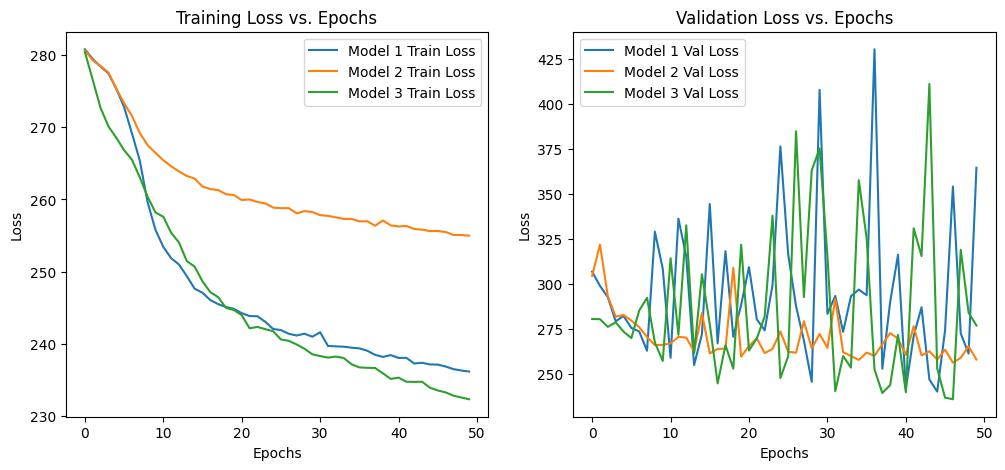

In [47]:
# base model

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Model 1 Train Loss')
plt.plot(history2.history['loss'], label='Model 2 Train Loss')
plt.plot(history3.history['loss'], label='Model 3 Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], label='Model 1 Val Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Val Loss')
plt.plot(history3.history['val_loss'], label='Model 3 Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss vs. Epochs")
plt.legend()

plt.show()

In [48]:
tonum3d1 = {
    'r': -np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'n': -np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'b': -np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'q': -np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'k': -np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'p': -np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),

    'R': np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'N': np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'B': np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'Q': np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'K': np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'P': np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),
}

# p1, bn3, r5, q9, k10

tonum3d2 = {
    'r': -5*np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'n': -3*np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'b': -3*np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'q': -9*np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'k': -10*np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'p': -np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),

    'R': 5*np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'N': 3*np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'B': 3*np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'Q': 9*np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'K': 10*np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'P': np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),
}



def fen2cube(fen, tonum3d):
    board = np.zeros((8, 8, 8), dtype=np.float32)
    for i, row in enumerate(fen.split('/')):
        j = 0
        for c in row:
            if c.isdigit():
                j += int(c)
            else:
                board[i, j] = tonum3d[c]
                j += 1
    return board

In [49]:
df['cube1'] = df['FEN_board'].apply(lambda x: fen2cube(x, tonum3d1))
df['cube2'] = df['FEN_board'].apply(lambda x: fen2cube(x, tonum3d2))

/tmp/ipykernel_43912/1100984881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cube1'] = df['FEN_board'].apply(lambda x: fen2cube(x, tonum3d1))
/tmp/ipykernel_43912/1100984881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cube2'] = df['FEN_board'].apply(lambda x: fen2cube(x, tonum3d2))


In [50]:
cubestacked1 = np.stack(df['cube1'].values)
cubestacked2 = np.stack(df['cube2'].values)

In [51]:
(cube1tr, cube1val,
 vec1tr1_3d, vec1val1_3d,
 vec2tr1_3d, vec2val1_3d,
 ytr3d, yval3d) = train_test_split(
    cubestacked1, vecinp1, vecinp2,  y,
    test_size=0.2,
    random_state=42
)

(cube2tr, cube2val,
 vec1tr2_3d, vec1val2_3d,
 vec2tr2_3d, vec2val2_3d,
 ytr3d, yval3d) = train_test_split(
    cubestacked1, vecinp1, vecinp2, y,
    test_size=0.2,
    random_state=42
)

In [52]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def makemodel3d_base():
    cube_input = Input(shape=(8, 8, 8), name='image_input')

    casting = layers.Conv2D(16, (3, 3), activation=None, padding='same')(cube_input)
    casting = layers.BatchNormalization()(casting)

    x = layers.Conv2D(16, (3, 3), activation=None, padding='same')(casting)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (2, 2), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    vector_input1 = Input(shape=(4,), name='vector_input1')
    y1 = layers.Dense(16, activation='relu')(vector_input1)
    y1 = layers.Dense(32, activation='relu')(y1)

    vector_input2 = Input(shape=(3,), name='vector_input2')
    y2 = layers.Dense(16, activation='relu')(vector_input2)
    y2 = layers.Dense(32, activation='relu')(y2)

    # vector_input3 = Input(shape=(2,), name='vector_input3')
    # y3 = layers.Dense(16, activation='relu')(vector_input3)
    # y3 = layers.Dense(32, activation='relu')(y3)

    combined = layers.Concatenate()([x, y1, y2])

    z = layers.Dense(128, activation=None)(combined)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(64, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dropout(0.5)(z)

    z = layers.Dense(32, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(16, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(4, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    output = layers.Dense(1, activation='linear', name='output')(z)

    model = Model(inputs=[cube_input, vector_input1, vector_input2], outputs=output)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-2,
        weight_decay=1e-3
    )

    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    return model


In [53]:
xtr1_3d = [cube1tr, vec1tr1_3d, vec2tr1_3d]
xtr2_3d = [cube2tr, vec1tr2_3d, vec2tr2_3d]
xval1_3d = [cube1val, vec1val1_3d, vec2val1_3d]
xval2_3d = [cube2val, vec1val2_3d, vec2val2_3d]

model1_3d = makemodel3d_base()
model2_3d = makemodel3d_base()

In [54]:
history1_3d = model1_3d.fit(
    xtr1_3d,
    ytr3d,
    validation_data=(xval1_3d, yval3d),
    epochs=50,
    batch_size=2048
)

Epoch 1/50
116/116 [==============================] - 7s 13ms/step - loss: 277.9004 - mean_squared_error: 150598.3750 - mean_absolute_error: 277.9004 - val_loss: 282.3285 - val_mean_squared_error: 142361.7812 - val_mean_absolute_error: 282.3285
Epoch 2/50
116/116 [==============================] - 1s 10ms/step - loss: 260.8926 - mean_squared_error: 134293.9219 - mean_absolute_error: 260.8926 - val_loss: 326.0448 - val_mean_squared_error: 170851.6562 - val_mean_absolute_error: 326.0448
Epoch 3/50
116/116 [==============================] - 1s 11ms/step - loss: 233.8580 - mean_squared_error: 109272.2891 - mean_absolute_error: 233.8580 - val_loss: 381.6759 - val_mean_squared_error: 206577.2656 - val_mean_absolute_error: 381.6759
Epoch 4/50
116/116 [==============================] - 1s 11ms/step - loss: 202.2658 - mean_squared_error: 83954.7266 - mean_absolute_error: 202.2658 - val_loss: 403.1557 - val_mean_squared_error: 207224.7656 - val_mean_absolute_error: 403.1557
Epoch 5/50
116/116 [=

In [55]:
history2_3d = model2_3d.fit(
    xtr2_3d,
    ytr3d,
    validation_data=(xval2_3d, yval3d),
    epochs=50,
    batch_size=2048
)

Epoch 1/50
116/116 [==============================] - 6s 12ms/step - loss: 278.5039 - mean_squared_error: 150907.0312 - mean_absolute_error: 278.5039 - val_loss: 246.5511 - val_mean_squared_error: 119864.6016 - val_mean_absolute_error: 246.5511
Epoch 2/50
116/116 [==============================] - 1s 9ms/step - loss: 264.3704 - mean_squared_error: 136990.0000 - mean_absolute_error: 264.3704 - val_loss: 261.6989 - val_mean_squared_error: 124340.0000 - val_mean_absolute_error: 261.6989
Epoch 3/50
116/116 [==============================] - 1s 9ms/step - loss: 242.7407 - mean_squared_error: 118202.0234 - mean_absolute_error: 242.7407 - val_loss: 266.6601 - val_mean_squared_error: 134695.4844 - val_mean_absolute_error: 266.6601
Epoch 4/50
116/116 [==============================] - 1s 9ms/step - loss: 223.8360 - mean_squared_error: 105538.6875 - mean_absolute_error: 223.8360 - val_loss: 266.3167 - val_mean_squared_error: 134557.2188 - val_mean_absolute_error: 266.3167
Epoch 5/50
116/116 [===

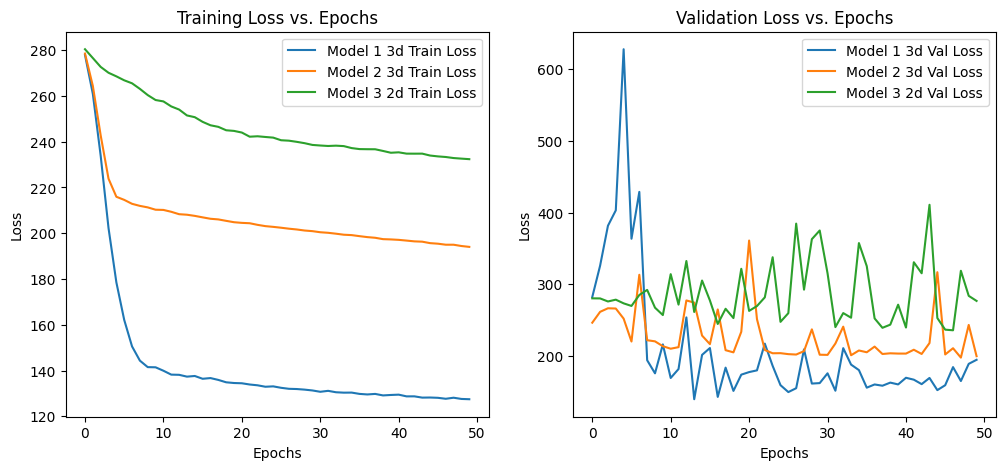

In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1_3d.history['loss'], label='Model 1 3d Train Loss')
plt.plot(history2_3d.history['loss'], label='Model 2 3d Train Loss')
plt.plot(history3.history['loss'], label='Model 3 2d Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1_3d.history['val_loss'], label='Model 1 3d Val Loss')
plt.plot(history2_3d.history['val_loss'], label='Model 2 3d Val Loss')
plt.plot(history3.history['val_loss'], label='Model 3 2d Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss vs. Epochs")
plt.legend()

plt.show()


In [57]:
histories = {
    "history1": history1,
    "history2": history2,
    "history3": history3,
    "history1_3d": history1_3d,
    "history2_3d": history2_3d
}

best_losses = {}

for name, history in histories.items():
    best_train_loss = min(history.history['loss'])
    best_val_loss = min(history.history['val_loss'])
    best_losses[name] = (best_train_loss, best_val_loss)

    print(f"{name}:")
    print(f"  Best Training Loss: {best_train_loss}")
    print(f"  Best Validation Loss: {best_val_loss}\n")

best_model = min(best_losses, key=lambda k: best_losses[k][1])
print(f"The best model is {best_model} with validation loss {best_losses[best_model][1]}")


history1:
  Best Training Loss: 236.19140625
  Best Validation Loss: 240.22947692871094

history2:
  Best Training Loss: 254.98753356933594
  Best Validation Loss: 256.29095458984375

history3:
  Best Training Loss: 232.3675079345703
  Best Validation Loss: 235.98904418945312

history1_3d:
  Best Training Loss: 127.49275207519531
  Best Validation Loss: 139.90948486328125

history2_3d:
  Best Training Loss: 194.04373168945312
  Best Validation Loss: 197.9021759033203

The best model is history1_3d with validation loss 139.90948486328125


In [60]:
def makemodel3d():
    cube_input = Input(shape=(8, 8, 8), name='image_input')

    casting = layers.Conv2D(16, (3, 3), activation=None, padding='same')(cube_input)
    casting = layers.BatchNormalization()(casting)

    x = layers.Conv2D(16, (3, 3), activation=None, padding='same')(casting)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (2, 2), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    vector_input1 = Input(shape=(4,), name='vector_input1')
    y1 = layers.Dense(16, activation='relu')(vector_input1)
    y1 = layers.Dense(32, activation='relu')(y1)

    vector_input2 = Input(shape=(3,), name='vector_input2')
    y2 = layers.Dense(16, activation='relu')(vector_input2)
    y2 = layers.Dense(32, activation='relu')(y2)

    vector_input3 = Input(shape=(2,), name='vector_input3')
    y3 = layers.Dense(16, activation='relu')(vector_input3)
    y3 = layers.Dense(32, activation='relu')(y3)

    combined = layers.Concatenate()([x, y1, y2, y3])

    z = layers.Dense(128, activation=None)(combined)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(64, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dropout(0.5)(z)

    z = layers.Dense(32, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(16, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(4, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    output = layers.Dense(1, activation='linear', name='output')(z)

    model = Model(inputs=[cube_input, vector_input1, vector_input2, vector_input3], outputs=output)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-2,
        weight_decay=1e-3
    )

    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    return model


In [61]:
history2_3d

In [62]:
model3d_feature = makemodel3d()
model3d_feature.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 8, 8, 8)]            0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 8, 8, 16)             1168      ['image_input[0][0]']         
                                                                                                  
 batch_normalization_45 (Ba  (None, 8, 8, 16)             64        ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_21 (Conv2D)          (None, 8, 8, 16)             2320      ['batch_normalization_45

In [63]:
!pip install pydot

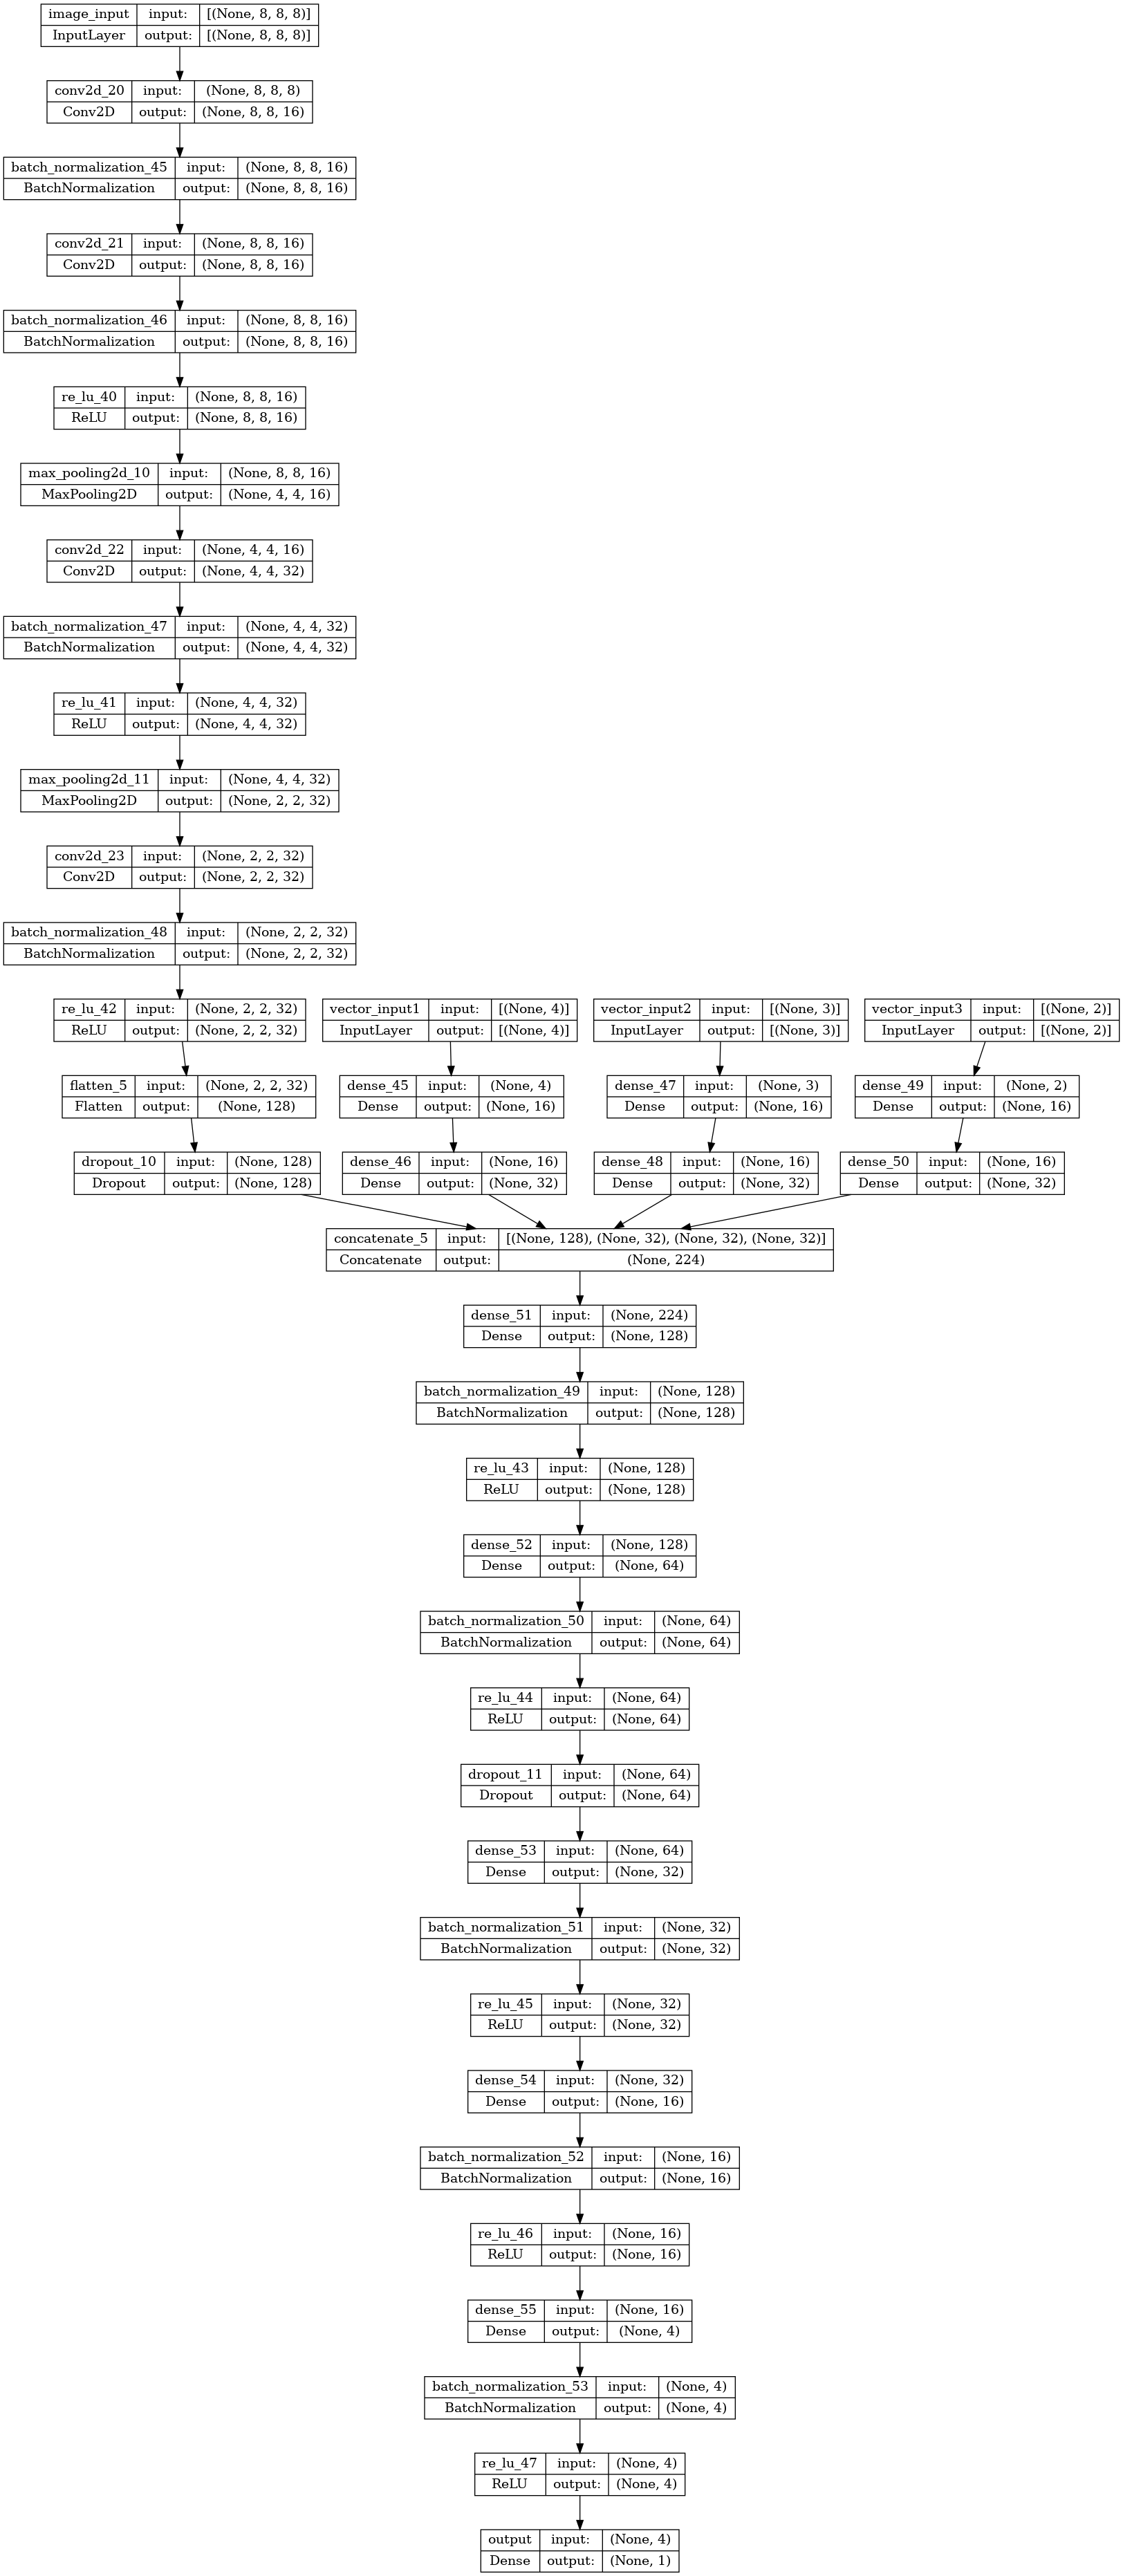

In [64]:
from tensorflow.keras.utils import plot_model
plot_model(model3d_feature, to_file='model3d_feature.png', show_shapes=True, show_layer_names=True)

In [65]:
vecinp1.shape, vecinp2.shape, vecinp3.shape

((295749, 4), (295749, 3), (295749, 2))

In [66]:
(cubetr1, cubeval1,
 vec1tr1, vec1val1,
 vec2tr1, vec2val1,
 vec3tr1, vec3val1,
 ytr1, yval1) = train_test_split(
    cubestacked1,
    vecinp1,
    vecinp2,
    vecinp3,
    y,
    test_size=0.2,
    random_state=42
)

In [67]:
xtr1 = [cubetr1, vec1tr1, vec2tr1, vec3tr1]
xval1 = [cubeval1, vec1val1, vec2val1, vec3val1]

In [68]:
history3d_features = model3d_feature.fit(
    xtr1,
    ytr1,
    validation_data=(xval1, yval1),
    epochs=50,
    batch_size=2048
)

Epoch 1/50
116/116 [==============================] - 6s 12ms/step - loss: 277.4030 - mean_squared_error: 150130.6719 - mean_absolute_error: 277.4030 - val_loss: 265.7156 - val_mean_squared_error: 135306.6250 - val_mean_absolute_error: 265.7156
Epoch 2/50
116/116 [==============================] - 1s 10ms/step - loss: 261.3219 - mean_squared_error: 135345.1719 - mean_absolute_error: 261.3219 - val_loss: 242.0725 - val_mean_squared_error: 110487.1484 - val_mean_absolute_error: 242.0725
Epoch 3/50
116/116 [==============================] - 1s 10ms/step - loss: 233.8880 - mean_squared_error: 111157.9609 - mean_absolute_error: 233.8880 - val_loss: 212.5335 - val_mean_squared_error: 88452.8594 - val_mean_absolute_error: 212.5335
Epoch 4/50
116/116 [==============================] - 1s 10ms/step - loss: 201.0984 - mean_squared_error: 85433.2344 - mean_absolute_error: 201.0984 - val_loss: 205.9128 - val_mean_squared_error: 77990.9141 - val_mean_absolute_error: 205.9128
Epoch 5/50
116/116 [===

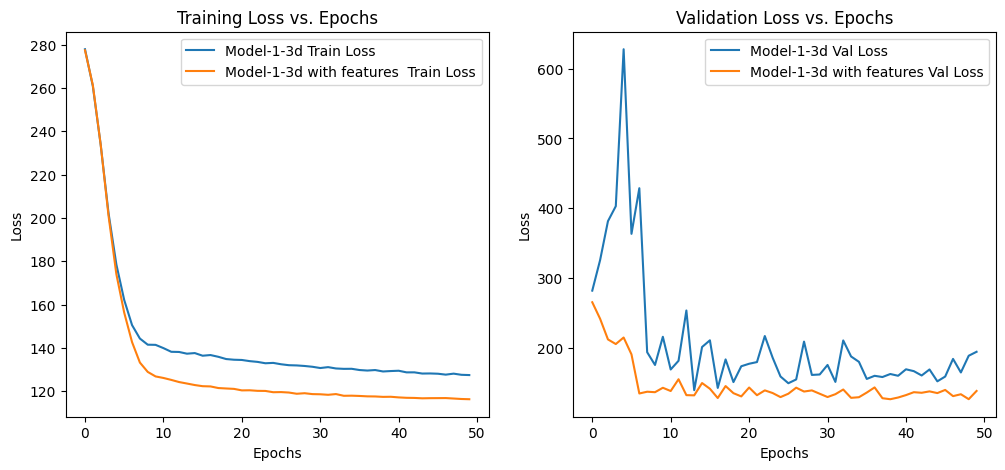

In [69]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1_3d.history['loss'], label='Model-1-3d Train Loss')
plt.plot(history3d_features.history['loss'], label='Model-1-3d with features  Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1_3d.history['val_loss'], label='Model-1-3d Val Loss')
plt.plot(history3d_features.history['val_loss'], label='Model-1-3d with features Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss vs. Epochs")
plt.legend()

plt.show()


In [70]:
@tf.function
def custom_loss(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float64)
    y_true = tf.cast(y_true, tf.float64)

    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, -1 + epsilon, 1 - epsilon)
    y_true = tf.clip_by_value(y_true, -1 + epsilon, 1 - epsilon)

    y_pred_transformed = 994.33977 * tf.math.atanh(y_pred)
    y_true_transformed = 994.33977 * tf.math.atanh(y_true)

    return tf.reduce_mean(tf.abs(y_pred_transformed - y_true_transformed))


In [71]:
def makemodel3d_f():
    cube_input = Input(shape=(8, 8, 8), name='image_input', dtype=tf.float64)

    casting = layers.Conv2D(16, (3, 3), activation=None, padding='same', dtype=tf.float64)(cube_input)
    casting = layers.BatchNormalization(dtype=tf.float64)(casting)

    x = layers.Conv2D(16, (3, 3), activation=None, padding='same', dtype=tf.float64)(casting)
    x = layers.BatchNormalization(dtype=tf.float64)(x)
    x = layers.ReLU(dtype=tf.float64)(x)

    x = layers.MaxPooling2D((2, 2), dtype=tf.float64)(x)

    x = layers.Conv2D(32, (3, 3), activation=None, padding='same', dtype=tf.float64)(x)
    x = layers.BatchNormalization(dtype=tf.float64)(x)
    x = layers.ReLU(dtype=tf.float64)(x)

    x = layers.MaxPooling2D((2, 2), dtype=tf.float64)(x)

    x = layers.Conv2D(32, (2, 2), activation=None, padding='same', dtype=tf.float64)(x)
    x = layers.BatchNormalization(dtype=tf.float64)(x)
    x = layers.ReLU(dtype=tf.float64)(x)

    x = layers.Flatten(dtype=tf.float64)(x)
    x = layers.Dropout(0.5, dtype=tf.float64)(x)

    vector_input1 = Input(shape=(4,), name='vector_input1', dtype=tf.float64)
    y1 = layers.Dense(16, activation='relu', dtype=tf.float64)(vector_input1)
    y1 = layers.Dense(32, activation='relu', dtype=tf.float64)(y1)

    vector_input2 = Input(shape=(3,), name='vector_input2', dtype=tf.float64)
    y2 = layers.Dense(16, activation='relu', dtype=tf.float64)(vector_input2)
    y2 = layers.Dense(32, activation='relu', dtype=tf.float64)(y2)

    vector_input3 = Input(shape=(2,), name='vector_input3', dtype=tf.float64)
    y3 = layers.Dense(16, activation='relu', dtype=tf.float64)(vector_input3)
    y3 = layers.Dense(32, activation='relu', dtype=tf.float64)(y3)

    combined = layers.Concatenate(dtype=tf.float64)([x, y1, y2, y3])

    z = layers.Dense(128, activation=None, dtype=tf.float64)(combined)
    z = layers.BatchNormalization(dtype=tf.float64)(z)
    z = layers.ReLU(dtype=tf.float64)(z)

    z = layers.Dense(64, activation=None, dtype=tf.float64)(z)
    z = layers.BatchNormalization(dtype=tf.float64)(z)
    z = layers.ReLU(dtype=tf.float64)(z)

    z = layers.Dropout(0.5, dtype=tf.float64)(z)

    z = layers.Dense(32, activation=None, dtype=tf.float64)(z)
    z = layers.BatchNormalization(dtype=tf.float64)(z)
    z = layers.ReLU(dtype=tf.float64)(z)

    z = layers.Dense(16, activation=None, dtype=tf.float64)(z)
    z = layers.BatchNormalization(dtype=tf.float64)(z)
    z = layers.ReLU(dtype=tf.float64)(z)

    z = layers.Dense(4, activation=None, dtype=tf.float64)(z)
    z = layers.BatchNormalization(dtype=tf.float64)(z)
    z = layers.ReLU(dtype=tf.float64)(z)

    output = layers.Dense(1, activation='tanh', name='output', dtype=tf.float64)(z)

    model = Model(inputs=[cube_input, vector_input1, vector_input2, vector_input3], outputs=output)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-2,
        weight_decay=1e-3
    )

    model.compile(
        optimizer=optimizer,
        loss=custom_loss,
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    return model


In [77]:
y_f = df['Evaluation'].div(994.33977).pipe(np.tanh).round(10)
y_f = y_f.values


In [78]:
(cube1tr_f, cube1val_f,
 vec1tr1_3d_f, vec1val1_3d_f,
 vec2tr1_3d_f, vec2val1_3d_f,
 vec3tr1_3d_f, vec3val1_3d_f,
 ytr3d_f, yval3d_f) = train_test_split(
    cubestacked1, vecinp1, vecinp2, vecinp3, y_f,
    test_size=0.2,
    random_state=42
 )

In [79]:
xtr1_3d_f = [cube1tr_f, vec1tr1_3d_f, vec2tr1_3d_f, vec3tr1_3d_f]
xval1_3d_f = [cube1val_f, vec1val1_3d_f, vec2val1_3d_f, vec3val1_3d_f]

model1_3d_f = makemodel3d_f()
model1_3d_f.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 8, 8, 8)]            0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 8, 8, 16)             1168      ['image_input[0][0]']         
                                                                                                  
 batch_normalization_63 (Ba  (None, 8, 8, 16)             64        ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_29 (Conv2D)          (None, 8, 8, 16)             2320      ['batch_normalization_63

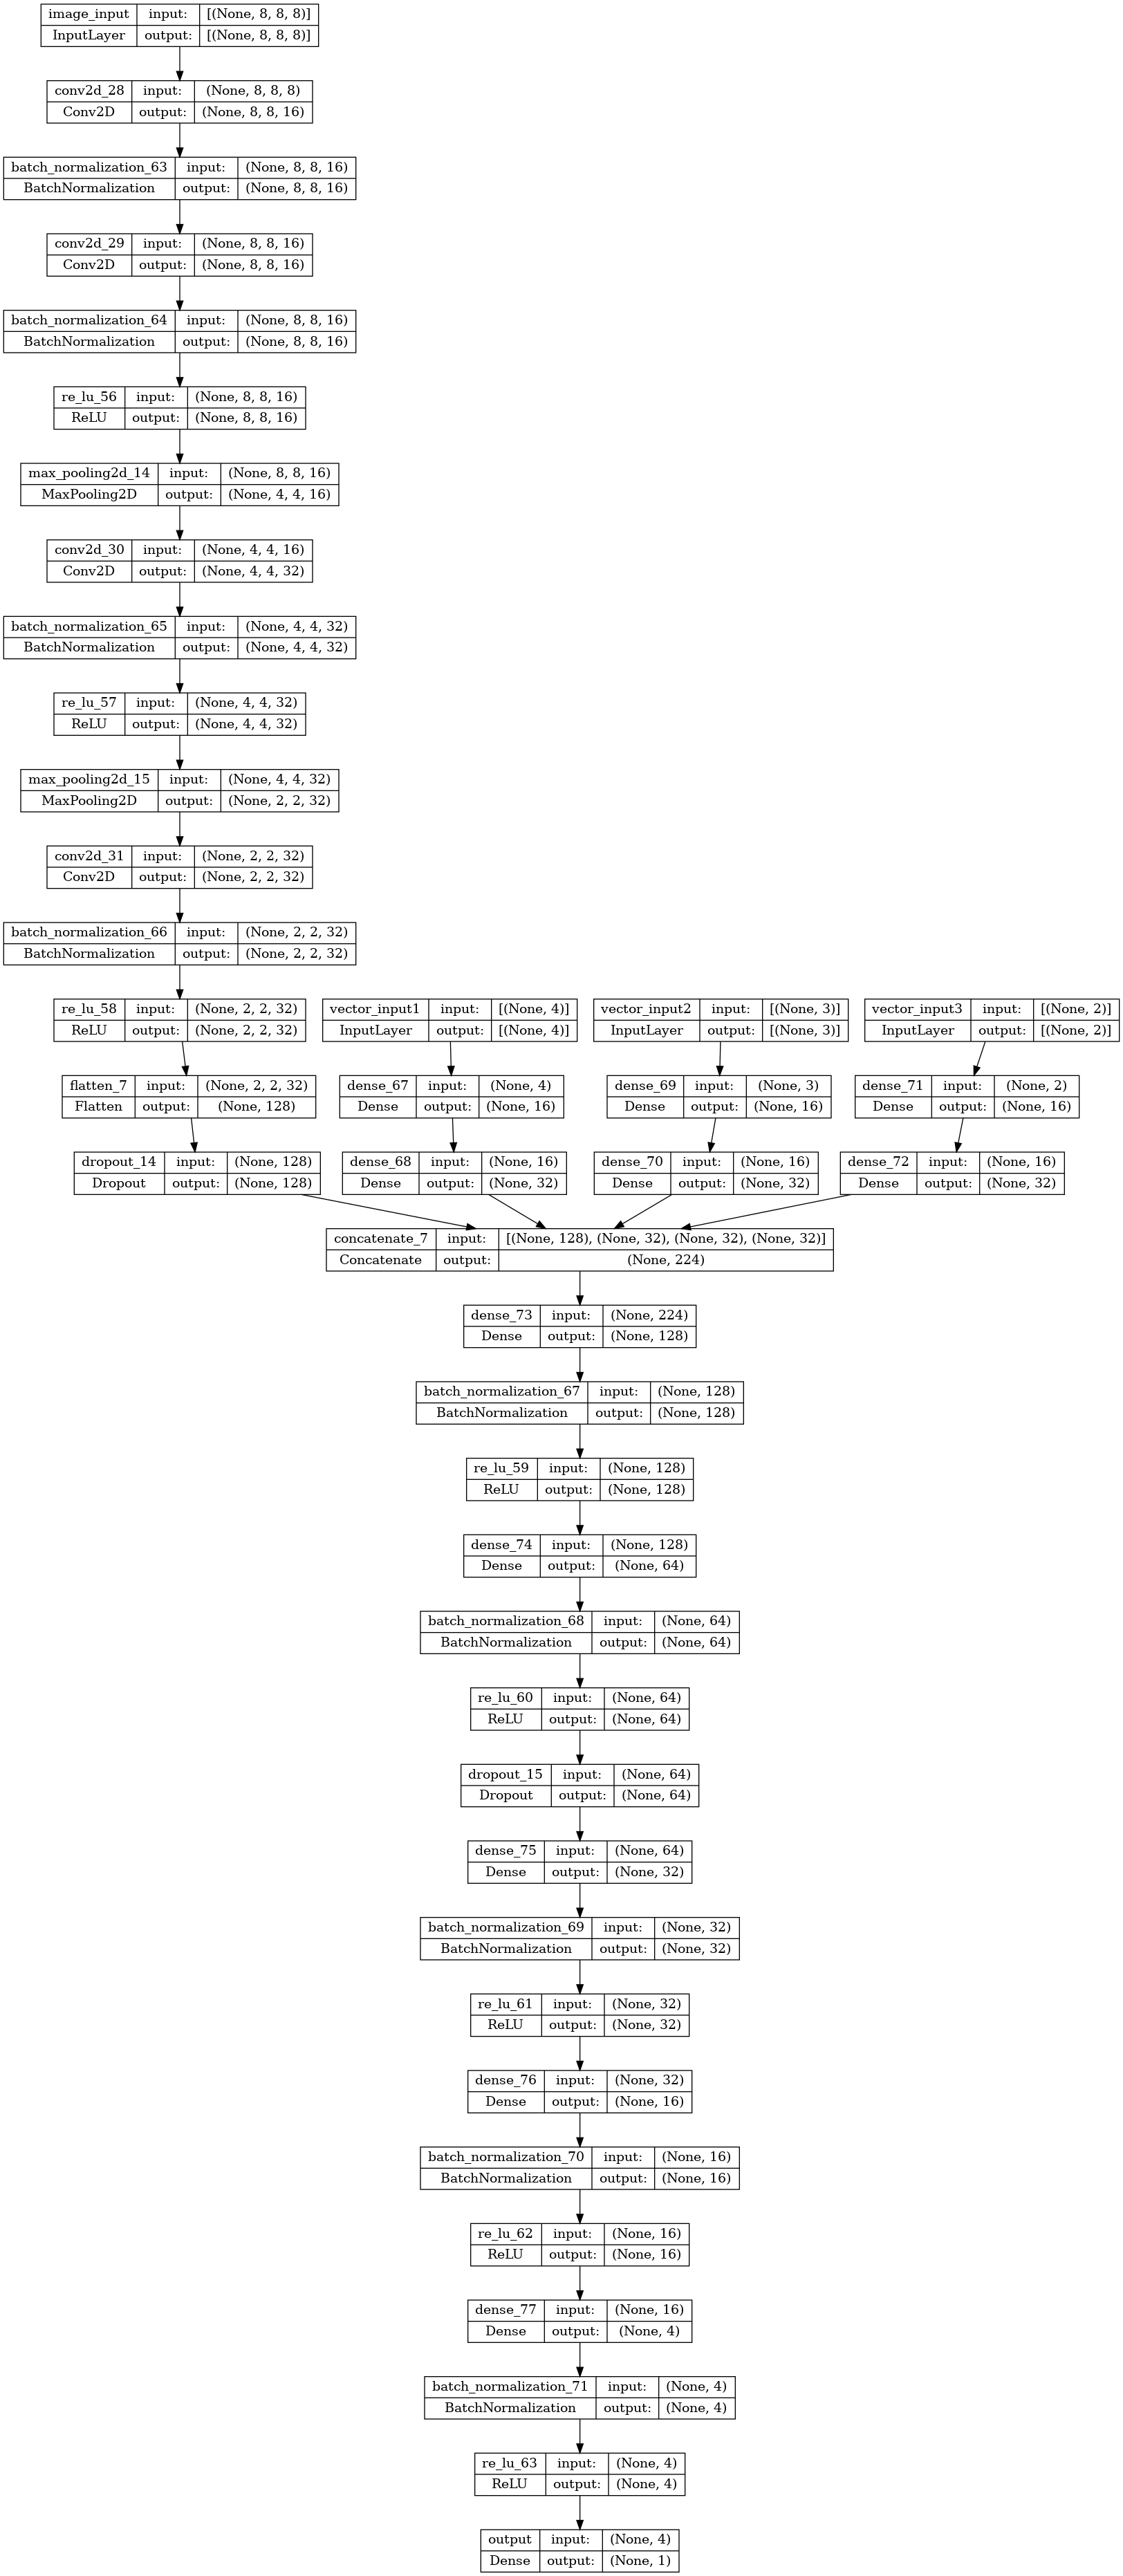

In [80]:
from tensorflow.keras.utils import plot_model
plot_model(model1_3d_f, to_file='model.png', show_shapes=True, show_layer_names=True)

In [81]:
history1_3d_f = model1_3d_f.fit(
    xtr1_3d_f,
    ytr3d_f,
    validation_data=(xval1_3d_f, yval3d_f),
    epochs=50,
    batch_size=2048
)

Epoch 1/50


116/116 [==============================] - 11s 22ms/step - loss: 197.1190 - mean_squared_error: 0.0602 - mean_absolute_error: 0.1620 - val_loss: 219.3109 - val_mean_squared_error: 0.0525 - val_mean_absolute_error: 0.1737
Epoch 2/50
116/116 [==============================] - 2s 18ms/step - loss: 146.1399 - mean_squared_error: 0.0344 - mean_absolute_error: 0.1279 - val_loss: 187.1190 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1653
Epoch 3/50
116/116 [==============================] - 2s 17ms/step - loss: 139.4575 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1219 - val_loss: 150.4353 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1323
Epoch 4/50
116/116 [==============================] - 2s 17ms/step - loss: 137.2036 - mean_squared_error: 0.0315 - mean_absolute_error: 0.1198 - val_loss: 163.2557 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1451
Epoch 5/50
116/116 [==============================] - 2s 17ms/step - loss: 134.3829 - 

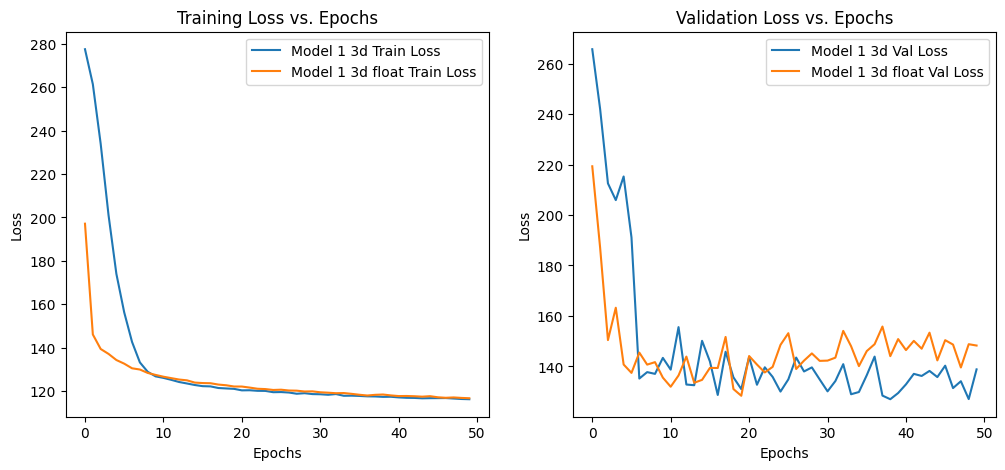

In [82]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history3d_features.history['loss'], label='Model 1 3d Train Loss')
plt.plot(history1_3d_f.history['loss'], label='Model 1 3d float Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3d_features.history['val_loss'], label='Model 1 3d Val Loss')
plt.plot(history1_3d_f.history['val_loss'], label='Model 1 3d float Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss vs. Epochs")
plt.legend()

plt.show()


In [84]:
# higher epoch vs higher data

In [85]:
df_compressed = df.sample(frac=0.5, random_state=42)

In [86]:
def makemodel3d():
    cube_input = Input(shape=(8, 8, 8), name='image_input')

    casting = layers.Conv2D(16, (3, 3), activation=None, padding='same')(cube_input)
    casting = layers.BatchNormalization()(casting)

    x = layers.Conv2D(16, (3, 3), activation=None, padding='same')(casting)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (2, 2), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    vector_input1 = Input(shape=(4,), name='vector_input1')
    y1 = layers.Dense(16, activation='relu')(vector_input1)
    y1 = layers.Dense(32, activation='relu')(y1)

    vector_input2 = Input(shape=(3,), name='vector_input2')
    y2 = layers.Dense(16, activation='relu')(vector_input2)
    y2 = layers.Dense(32, activation='relu')(y2)

    vector_input3 = Input(shape=(2,), name='vector_input3')
    y3 = layers.Dense(16, activation='relu')(vector_input3)
    y3 = layers.Dense(32, activation='relu')(y3)

    combined = layers.Concatenate()([x, y1, y2, y3])

    z = layers.Dense(128, activation=None)(combined)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(64, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dropout(0.5)(z)

    z = layers.Dense(32, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(16, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    z = layers.Dense(4, activation=None)(z)
    z = layers.BatchNormalization()(z)
    z = layers.ReLU()(z)

    output = layers.Dense(1, activation='linear', name='output')(z)

    model = Model(inputs=[cube_input, vector_input1, vector_input2, vector_input3], outputs=output)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-2,
        weight_decay=1e-3
    )

    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
    )

    return model


In [87]:
mdata = makemodel3d()


In [88]:
mepochs = makemodel3d()


In [89]:
vecinp1 = df[['CA_K', 'CA_Q', 'CA_k', 'CA_q']].to_numpy()
vecinp2 = df[['hm', 'fm', 'next']].astype(np.float32).to_numpy()
vecinp3 = df[['wtdb', 'wtdw']].astype(np.float32).to_numpy()

In [90]:
tonum3d2 = {
    'r': -5*np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'n': -3*np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'b': -3*np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'q': -9*np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'k': -10*np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'p': -np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),

    'R': 5*np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'N': 3*np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'B': 3*np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'Q': 9*np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'K': 10*np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'P': np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),
}



def fen2cube(fen, tonum3d):
    board = np.zeros((8, 8, 8), dtype=np.float32)
    for i, row in enumerate(fen.split('/')):
        j = 0
        for c in row:
            if c.isdigit():
                j += int(c)
            else:
                board[i, j] = tonum3d[c]
                j += 1
    return board

df['cube2'] = df['FEN_board'].apply(lambda x: fen2cube(x, tonum3d2))

/tmp/ipykernel_43912/3621827322.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cube2'] = df['FEN_board'].apply(lambda x: fen2cube(x, tonum3d2))


In [91]:
cubestacked2 = np.stack(df['cube2'].values)

In [92]:
y

array([  16, -929,    4, ...,  178,  357,  -53])

In [93]:
(cubetr1, cubeval1,
 vec1tr1, vec1val1,
 vec2tr1, vec2val1,
 vec3tr1, vec3val1,
 ytr1, yval1) = train_test_split(
    cubestacked2,
    vecinp1,
    vecinp2,
    vecinp3,
    y,
    test_size=0.2,
    random_state=42
)
xtr1 = [cubetr1, vec1tr1, vec2tr1, vec3tr1]
xval1 = [cubeval1, vec1val1, vec2val1, vec3val1]


In [94]:
historydata = mdata.fit(
    xtr1,
    ytr1,
    validation_data=(xval1, yval1),
    epochs=50,
    batch_size=2048
)

Epoch 1/50
116/116 [==============================] - 6s 13ms/step - loss: 277.5519 - mean_squared_error: 150303.1094 - mean_absolute_error: 277.5519 - val_loss: 269.6192 - val_mean_squared_error: 140979.5469 - val_mean_absolute_error: 269.6192
Epoch 2/50
116/116 [==============================] - 1s 12ms/step - loss: 261.4195 - mean_squared_error: 135374.1875 - mean_absolute_error: 261.4195 - val_loss: 227.5431 - val_mean_squared_error: 104039.2578 - val_mean_absolute_error: 227.5431
Epoch 3/50
116/116 [==============================] - 1s 12ms/step - loss: 233.8752 - mean_squared_error: 110509.7188 - mean_absolute_error: 233.8752 - val_loss: 202.4226 - val_mean_squared_error: 85707.1406 - val_mean_absolute_error: 202.4226
Epoch 4/50
116/116 [==============================] - 1s 10ms/step - loss: 201.4688 - mean_squared_error: 84492.5625 - mean_absolute_error: 201.4688 - val_loss: 178.8264 - val_mean_squared_error: 68866.1328 - val_mean_absolute_error: 178.8264
Epoch 5/50
116/116 [===

In [95]:
df_compressed

,Evaluation,FEN_board,next,hm,fm,CA_K,CA_Q,CA_k,CA_q,numb,...,Z_score,#B,#W,wtdb,wtdw,board1,board2,board3,cube1,cube2
2947,-578,8/8/p1pb1k1p/8/8/PKPr3P/1P6/8,1,7,56,0,0,0,0,"{'p': 3, 'r': 1, 'n': 0, 'b': 1, 'q': 0, 'k': 1}",...,-1.014338,6,5,-1235.989674,519.207287,"[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
74374,1590,8/4kB1R/1p5p/p1p5/P1PpP3/1P1P1qB1/7P/4R1K1,1,5,38,0,0,0,0,"{'p': 5, 'r': 0, 'n': 0, 'b': 0, 'q': 1, 'k': 1}",...,2.688190,7,11,-1589.572650,2470.042955,"[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
218366,-66,5b2/1p5p/1p3pp1/kPp1p3/2P1P1KP/P7/3N1P1P/8,1,1,35,0,0,0,0,"{'p': 7, 'r': 0, 'n': 0, 'b': 1, 'q': 0, 'k': 1}",...,-0.139940,9,9,-1280.297235,1225.574598,"[-32, 11, 49, -57, 109, -5, 0, 0, -32, -1, 49,...","[-32, 11, 49, -57, 109, 8, 0, 0, -32, 6, 49, -...","[-32, 11, 49, -57, 109, -5, 0, 0, -32, -1, 49,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
7901,-272,r2qk2r/p4ppp/1pn1P3/3Qn3/8/2Np4/PP1P1bPP/R1B1K2R,1,0,16,1,1,1,1,"{'p': 6, 'r': 2, 'n': 2, 'b': 1, 'q': 1, 'k': 1}",...,-0.491748,13,12,-3667.357145,3369.493263,"[-7, 11, 49, -15, -10, 127, 0, -7, -1, 11, 49,...","[9, 11, 49, 10, 11, 127, 0, 9, 6, 11, 49, -57,...","[-7, 11, 49, -15, -100, 127, 0, -7, -1, 11, 49...","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...","[[[-0.0, -40.0, -0.0, -40.0, -0.0, -40.0, -0.0..."
116335,-295,5rk1/pp2q1pp/1b2p1p1/3pP1Pn/PP4Q1/2P1P2P/8/RNB2K2,1,1,19,0,0,0,0,"{'p': 7, 'r': 1, 'n': 1, 'b': 1, 'q': 1, 'k': 1}",...,-0.531028,12,12,-3002.134678,3008.510628,"[-32, 11, 49, -57, 109, -7, -10, 0, -1, -1, 49...","[-32, 11, 49, -57, 109, 9, 11, 0, 6, 6, 49, -5...","[-32, 11, 49, -57, 109, -7, -100, 0, -1, -1, 4...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193649,436,2R5/6kp/4r3/p6p/1pK2P2/1B1P2P1/P6P/8,-1,0,48,0,0,0,0,"{'p': 4, 'r': 1, 'n': 0, 'b': 0, 'q': 0, 'k': 1}",...,0.717380,6,8,-1021.607787,1494.625121,"[-32, 11, 7, -57, 109, 127, 0, 0, -32, 11, 49,...","[-32, 11, 3, -57, 109, 127, 0, 0, -32, 11, 49,...","[-32, 11, 7, -57, 109, 127, 0, 0, -32, 11, 49,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
93380,692,8/7p/8/1P1k2p1/3P4/2K3P1/7P/8,-1,0,42,0,0,0,0,"{'p': 2, 'r': 0, 'n': 0, 'b': 0, 'q': 0, 'k': 1}",...,1.154579,3,5,-266.478837,519.207287,"[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[-32, 11, 49, -57, 109, 127, 0, 0, -32, 11, 49...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
96768,-501,5rk1/pp4pp/5p2/8/1P6/PqQ5/5PPP/R5K1,-1,0,27,0,0,0,0,"{'p': 5, 'r': 1, 'n': 0, 'b': 0, 'q': 1, 'k': 1}",...,-0.882837,8,8,-2078.222763,2077.113582,"[-97, -60, 100, -102, -71, -7, -10, 63, -1, -1...","[0, 0, 0, 0, 0, 9, 11, 0, 6, 6, 0, 0, 0, 0, 6,...","[0, 0, 0, 0, 0, -7, -100, 0, -1, -1, 0, 0, 0, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0..."
88881,-58,r1b3k1/1pq1r2p/p1n2bp1/2p3N1/2PpPpP1/N2P1P2/PP...,1,6,24,0,0,0,0,"{'p': 7, 'r': 2, 'n': 1, 'b': 2, 'q': 1, 'k': 1}",...,-0.126278,14,14,-3838.406097,3816.256932,"[-7, -53, -5, -65, 54, 115, -10, -65, 24, -1, ...","[9, 0, 8, 0, 0, 0, 11, 0, 0, 6, 10, 0, 9, 0, 0...","[-7, 0, -5, 0, 0, 0, -100, 0, 0, -1, -15, 0, -...","[[[-0.0, -8.0, -0.0, -8.0, -0.0, -8.0, -0.0, -...","[[[-0.0, -40.0, -0.0, -40.0, -0.0, -40.0, -0.0..."


In [96]:
y = df_compressed["Evaluation"].values


In [97]:
vecinp1 = df_compressed[['CA_K', 'CA_Q', 'CA_k', 'CA_q']].to_numpy()
vecinp2 = df_compressed[['hm', 'fm', 'next']].astype(np.float32).to_numpy()
vecinp3 = df_compressed[['wtdb', 'wtdw']].astype(np.float32).to_numpy()

y = df_compressed["Evaluation"].values

tonum3d2 = {
    'r': -5*np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'n': -3*np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'b': -3*np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'q': -9*np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'k': -10*np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'p': -np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),

    'R': 5*np.array([0, 8, 0, 8, 0, 8, 0, 8], dtype=np.float32),
    'N': 3*np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], dtype=np.float32),
    'B': 3*np.array([8, 0, 8, 0, 8, 0, 8, 0], dtype=np.float32),
    'Q': 9*np.array([8, 8, 8, 8, 8, 8, 8, 8], dtype=np.float32),
    'K': 10*np.array([1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float32),
    'P': np.array([0, 0, 0, 0, 0, 1, 0, 0], dtype=np.float32),
}



def fen2cube(fen, tonum3d):
    board = np.zeros((8, 8, 8), dtype=np.float32)
    for i, row in enumerate(fen.split('/')):
        j = 0
        for c in row:
            if c.isdigit():
                j += int(c)
            else:
                board[i, j] = tonum3d[c]
                j += 1
    return board

df_compressed['cube2'] = df_compressed['FEN_board'].apply(lambda x: fen2cube(x, tonum3d2))
cubestacked2 = np.stack(df_compressed['cube2'].values)

(cubetr1, cubeval1,
 vec1tr1, vec1val1,
 vec2tr1, vec2val1,
 vec3tr1, vec3val1,
 ytr1, yval1) = train_test_split(
    cubestacked2,
    vecinp1,
    vecinp2,
    vecinp3,
    y,
    test_size=0.2,
    random_state=42
)

xtr1 = [cubetr1, vec1tr1, vec2tr1, vec3tr1]
xval1 = [cubeval1, vec1val1, vec2val1, vec3val1]

In [98]:
cubetr1.shape

(118299, 8, 8, 8)

In [99]:
historyepochs = mepochs.fit(
    xtr1,
    ytr1,
    validation_data=(xval1, yval1),
    epochs=100,
    batch_size=2048
)

Epoch 1/100
58/58 [==============================] - 6s 22ms/step - loss: 280.6973 - mean_squared_error: 153327.7812 - mean_absolute_error: 280.6973 - val_loss: 276.7273 - val_mean_squared_error: 149876.2969 - val_mean_absolute_error: 276.7273
Epoch 2/100
58/58 [==============================] - 1s 10ms/step - loss: 276.1205 - mean_squared_error: 149065.5000 - mean_absolute_error: 276.1205 - val_loss: 267.9309 - val_mean_squared_error: 141989.3594 - val_mean_absolute_error: 267.9309
Epoch 3/100
58/58 [==============================] - 1s 10ms/step - loss: 267.9023 - mean_squared_error: 141432.9688 - mean_absolute_error: 267.9023 - val_loss: 254.0384 - val_mean_squared_error: 128442.8594 - val_mean_absolute_error: 254.0384
Epoch 4/100
58/58 [==============================] - 1s 11ms/step - loss: 256.2406 - mean_squared_error: 130623.6406 - mean_absolute_error: 256.2406 - val_loss: 233.7321 - val_mean_squared_error: 110099.7969 - val_mean_absolute_error: 233.7321
Epoch 5/100
58/58 [=====

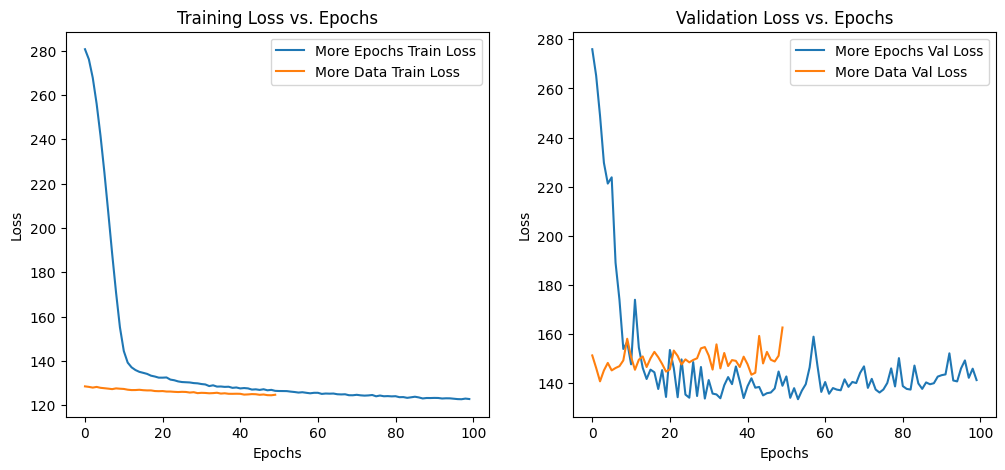

In [344]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historyepochs.history['loss'], label='More Epochs Train Loss')
plt.plot(historydata.history['loss'], label='More Data Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historyepochs.history['val_loss'], label='More Epochs Val Loss')
plt.plot(historydata.history['val_loss'], label='More Data Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss vs. Epochs")
plt.legend()

plt.show()